In [207]:
from utils_v1 import *


In [208]:
from icecream import ic
import pdb
from sklearn import metrics
import importlib
import utils_v1
import pathlib
import cv2
import sys
import numpy as np
from src import metrics as _metrics
import src.loss as loss
from src.dataset import (
    MultipleDates,
    PA, PADeforestationTime, PADistanceMap, PAMultipleDates,
    MT, MTDeforestationTime,
    MTMultipleDates
)

# from src.dataset_legacy import MTDeforestationTime
from src import training_generator as generator
from src.patchesHandler import PatchesHandler, PatchesHandlerMultipleDates


In [209]:
from enum import Enum
Predictor = Enum('Predictor', 'pred_var MI pred_entropy KL pred_entropy_single')
predictor = Predictor.pred_entropy
# predictor = Predictor.pred_var
# predictor = Predictor.MI
# predictor = Predictor.KL

# predictor = Predictor.pred_entropy_single


In [210]:
useLessInferenceRuns = False
reducedInferenceRuns = 30

In [211]:
training = False
save_probabilities = False
loadInference = False


addPastDeforestationInput = True
'''
if training == True:
	dates = [2017, 2018]
else:
	dates = [2018, 2019]
if training == True:
	dates = [2018, 2019]
else:
	dates = [2019, 2020]
'''
dates = [2018, 2019]
dataset = PAMultipleDates(dates = dates, # dates = [2017, 2018, 2019]. [2018, 2019]. [2015, 2016, 2017, 2018]
	addPastDeforestationInput = addPastDeforestationInput,
	borderBuffer = 2)	
# dates = [2019, 2020]
# dataset = MTMultipleDates(dates = dates, # dates = [2016,2017,2018,2019]
# 	addPastDeforestationInput = addPastDeforestationInput,
# 	borderBuffer = 2)	

if issubclass(type(dataset), MultipleDates):
	patchesHandler = PatchesHandlerMultipleDates(
		dataset)
else:
	patchesHandler = PatchesHandler()

inference_times = 10


if training == False:


	if type(dataset) == PAMultipleDates:
		exp_ids = [103, 104, 105, 106, 107, 118, 119, 120, 121, 122] # same date
		# exp_ids = [123, 124, 125, 126, 127, 128, 129, 131, 1122, 1121] # earlier date

	if type(dataset) == MTMultipleDates:
		exp_ids = [108, 109, 110, 111, 112, 113, 114, 115, 116, 117] # same date
		# exp_ids = [130, 132, 133, 134, 135, 136, 137, 1125, 1124, 1123] # earlier date

else:
	# exp = 13 # Multiple dates. using fixed fixed past deforestation distance
	exp = 140

ic| list(self.date_ids): [0]
ic| self.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]
ic| self.input_image_shape: 21
ic| self.dataset.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]


In [212]:
exp_ids

[103, 104, 105, 106, 107, 118, 119, 120, 121, 122]

In [213]:
figures_path = 'figures' + dataset.__class__.__name__ + '/'
pathlib.Path(figures_path).mkdir(parents=True, exist_ok=True)
title_name = 'ResUnet'

In [214]:
# ic(type(dataset), exp, dataset.dates)


In [215]:
# Loading reference
label_mask = dataset.loadLabel()
print('Mask label shape: ', '\n', label_mask.shape, '\n', 'Unique values: ', '\n', np.unique(label_mask))

D:/Jorge/datasets/deforestation/Para/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2019) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/deforestation_before_2008/deforestation_before_2008_para.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([124211220,  38957970], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))
ic| label_per_date.shape: (17730, 9203, 1)


Mask label shape:  
 (17730, 9203, 1) 
 Unique values:  
 [0 1 2]


In [216]:
# np.save('label_not_independent.npy', label_mask)


In [217]:
# Creating tile mask

mask_tiles = create_mask(label_mask.shape[0], label_mask.shape[1], 
        grid_size=(dataset.grid_x, dataset.grid_y))
label_mask = label_mask[:mask_tiles.shape[0], :mask_tiles.shape[1]]

Tiles size:  3546 2300
Mask size:  (17730, 9200)


In [218]:
label_mask.dtype

dtype('uint8')

In [219]:
label_mask_current_deforestation = dataset.getLabelCurrentDeforestation(
        label_mask)

In [220]:
label_mask.dtype

dtype('uint8')

In [221]:
# Loading image stack
image_stack = dataset.loadInputImage()

print('Image shape: ', image_stack.shape)
channels = image_stack.shape[-1]
image_stack = image_stack[:mask_tiles.shape[0], :mask_tiles.shape[1],:]
print('mask: ',mask_tiles.shape)
print('image stack: ', image_stack.shape)
print('ref :', label_mask.shape)
#plt.imshow(mask_tiles)

ic| image_stack.shape: (17730, 9203, 21)


Image shape:  (17730, 9203, 21)
mask:  (17730, 9200)
image stack:  (17730, 9200, 21)
ref : (17730, 9200, 1)


In [222]:
np.unique(image_stack[...,0], return_counts=True)

(array([0.        , 0.08333334, 0.16666667, 0.25      , 0.33333334,
        0.4166667 , 0.5       , 0.5833334 , 0.6666667 , 0.75      ,
        0.8333334 , 0.9166667 , 1.        ], dtype=float32),
 array([104050616,   2209014,    644713,    968315,   1458862,   1560879,
          2477424,   1299508,    903419,    864429,   4570932,   3150455,
         38957434], dtype=int64))

(-0.5, 9199.5, 17729.5, -0.5)

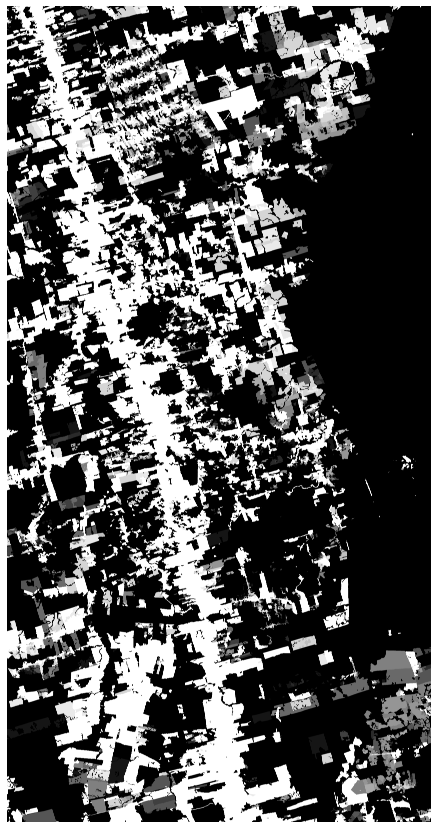

In [223]:


plt.figure(figsize=(15,15))
plt.imshow(image_stack[...,0], cmap=plt.cm.gray)

# title_name = 'ResUnet'
plt.axis('off')
# plt.savefig('figures/Para' + title_name + ' error mask.png', dpi=150, bbox_inches='tight')

In [224]:
ic(image_stack.shape)
channels = image_stack.shape[-1]
ic(channels)

ic| image_stack.shape: (17730, 9200, 21)
ic| channels: 21


21

In [225]:
mask_tr_val, mask_amazon_ts = dataset.getTrainValTestMasks(mask_tiles)


Training tiles:  [1, 3, 5, 8, 11, 13, 14, 20]
Validation tiles:  [6, 19]
Test tiles:  [2, 4, 7, 9, 10, 12, 15, 16, 17, 18]


In [226]:

patch_size = 128
if training == True:

    # Extracting patches from the idx matrix
    overlap = 0.7
    batch_size = 32
    im_idx = patchesHandler.create_idx_image(label_mask)


In [227]:
import importlib
if training == True:
	coords = patchesHandler.extract_patches(
		im_idx, patch_size=(patch_size, patch_size, 2), 
		overlap=overlap)

	coords_train, coords_val = patchesHandler.trainTestSplit(coords,
		mask_tr_val, patch_size=(patch_size, patch_size, 2))

	ic(coords_train.shape, coords_val.shape)
	# del im_idx

In [228]:
label_mask.shape

(17730, 9200, 1)

(-0.5, 9199.5, 17729.5, -0.5)

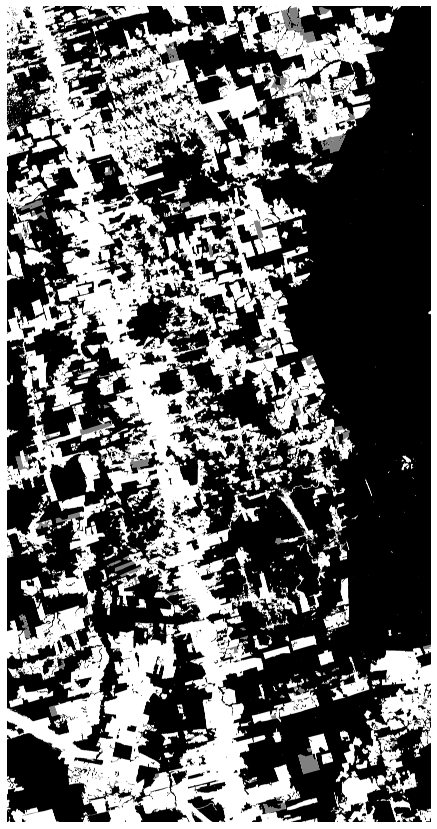

In [229]:

plt.figure(figsize=(15,15))
if type(dataset) != PADeforestationTime and type(dataset) != MTDeforestationTime:
    plt.imshow(label_mask[...,-1], cmap=plt.cm.gray)
else:
    plt.imshow(label_mask, cmap=plt.cm.gray)

# title_name = 'ResUnet'
plt.axis('off')
# plt.savefig('figures/Para' + title_name + ' error mask.png', dpi=150, bbox_inches='tight')

In [230]:
np.unique(label_mask)

array([0, 1, 2], dtype=uint8)

In [231]:
if training == True:
    print(coords_train)

In [232]:
if training == True:

    # Keeping patches with 2% of def class
    coords_train = patchesHandler.retrieve_idx_percentage(label_mask, coords_train, 
			patch_size, pertentage = 0.2)
    coords_val = patchesHandler.retrieve_idx_percentage(label_mask, coords_val, 
			patch_size, pertentage = 0.2)
    print('training samples: ', coords_train.shape, 
			'validation samples: ', coords_val.shape)


In [233]:
'''
import src.patchesHandler as sp
importlib.reload(sp)

patchesHandler = sp.PatchesHandlerMultipleDates(
		dataset)
'''

'\nimport src.patchesHandler as sp\nimportlib.reload(sp)\n\npatchesHandler = sp.PatchesHandlerMultipleDates(\n\t\tdataset)\n'

In [234]:
import src.plot as _plt
importlib.reload(_plt)

<module 'src.plot' from 'd:\\Jorge\\deforestation_uncertainty\\src\\plot.py'>

In [235]:
'''
if training == True:
    idx = 3100
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[4,5,6]]), np.mean(image_patch[...,[14,15,16]]))
    _plt.plotCropSample5(image_stack[...,[4,5,6]], image_stack[...,[14,15,16]], 
            image_stack[...,[24,25,26]], image_stack[...,[34,35,36]],
            image_stack[...,[44,45,46]],            
            lims = None, 
            titles = ['2015', '2016', '2017', '2018', '2019'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False, False],
            invertMask = [False, False, False, False, False])
'''

"\nif training == True:\n    idx = 3100\n    print(coords_train[idx])\n    image_patch, reference_patch = patchesHandler.getPatch(\n        image_stack, label_mask, coords_train, idx = idx)\n    ic(np.mean(image_patch[...,[4,5,6]]), np.mean(image_patch[...,[14,15,16]]))\n    _plt.plotCropSample5(image_stack[...,[4,5,6]], image_stack[...,[14,15,16]], \n            image_stack[...,[24,25,26]], image_stack[...,[34,35,36]],\n            image_stack[...,[44,45,46]],            \n            lims = None, \n            titles = ['2015', '2016', '2017', '2018', '2019'],\n            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],\n            maskBackground = [False, False, False, False, False],\n            invertMask = [False, False, False, False, False])\n"

In [236]:
inputSnipShow = False

In [237]:
if training == True and inputSnipShow == True:
    idx = 2800
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [238]:
'''
if training == True:

    idx = 6000
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])
'''

"\nif training == True:\n\n    idx = 6000\n    print(coords_train[idx])\n    image_patch, reference_patch = patchesHandler.getPatch(\n        image_stack, label_mask, coords_train, idx = idx)\n    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))\n    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], \n            reference_patch, reference_patch,\n            lims = None, \n            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],\n            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],\n            maskBackground = [False, False, False, False],\n            invertMask = [False, False, False, False])\n"

In [239]:
if training == True and inputSnipShow == True:

    idx = 97
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [240]:
if training == True and inputSnipShow == True:

    idx = 1200
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [241]:
inputSnipShow = False
if training == True and inputSnipShow == True:

    idx = 400
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [242]:
'''
if training == True:

    idx = 6000
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])
'''

"\nif training == True:\n\n    idx = 6000\n    print(coords_train[idx])\n    image_patch, reference_patch = patchesHandler.getPatch(\n        image_stack, label_mask, coords_train, idx = idx)\n    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))\n    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], \n            reference_patch, reference_patch,\n            lims = None, \n            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],\n            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],\n            maskBackground = [False, False, False, False],\n            invertMask = [False, False, False, False])\n"

In [243]:
# Creating train and validation data generator
# importlib.reload(patchesHandler)
import pdb
if training == True:

	train_datagen = ImageDataGenerator()
	valid_datagen = ImageDataGenerator()
	# pdb.set_trace()
	len_X_train = coords_train.shape[0]
	len_X_valid = coords_val.shape[0]

	train_gen = train_datagen.flow(
			np.expand_dims(np.expand_dims(coords_train, axis = -1), axis = -1), 
			np.expand_dims(np.expand_dims(coords_train, axis = -1), axis = -1),
			batch_size=batch_size,
			shuffle=True)
	# pdb.set_trace()

	valid_gen = valid_datagen.flow(
			np.expand_dims(np.expand_dims(coords_val, axis = -1), axis = -1), 
			np.expand_dims(np.expand_dims(coords_val, axis = -1), axis = -1),
			batch_size=batch_size,
			shuffle=False)

	number_class = 3
	train_gen_batch = patchesHandler.batch_generator(train_gen,
			image_stack, label_mask, patch_size, number_class)
	valid_gen_batch = patchesHandler.batch_generator(valid_gen,
			image_stack, label_mask, patch_size, number_class)

	#del image_stack

In [244]:
# Creating folder for the experiment

# path_exp = dataset.paths.experiment + 'exp' + str(exp)
# path_models = path_exp+'/models'
# path_maps = path_exp+'/pred_maps'

# if not os.path.exists(path_exp):
#     os.makedirs(path_exp)   
# if not os.path.exists(path_models):
#     os.makedirs(path_models)   
# if not os.path.exists(path_maps):
#     os.makedirs(path_maps)
    
times = 1
method = 'resunet'
nb_filters = [16, 32, 64, 128, 256]
weights = [0.1, 0.9, 0]

In [245]:
if type(patchesHandler) == PatchesHandlerMultipleDates:
	channels = patchesHandler.input_image_shape

In [246]:
# path_exp

In [247]:
channels

21

In [248]:
image_stack.shape

(17730, 9200, 21)

In [249]:

metrics_all = []
if training == True:
    for tm in range(0,times):
        print('time: ', tm)

        rows = patch_size
        cols = patch_size
        adam = Adam(lr = 1e-3 , beta_1=0.9)
        
        loss = loss.weighted_categorical_crossentropy(weights)
        
        input_shape = (rows, cols, channels)
        model = build_resunet_dropout_spatial(input_shape, nb_filters, number_class)
        
        model.compile(optimizer=adam, loss=loss, metrics=['accuracy'])
        model.summary()

        earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min')
        checkpoint = ModelCheckpoint(path_models+ '/' + method +'_'+str(tm)+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        lr_reduce = ReduceLROnPlateau(factor=0.9, min_delta=0.0001, patience=5, verbose=1)
        callbacks_list = [earlystop, checkpoint]
        # train the model
        start_training = time.time()
        history = model.fit_generator(train_gen_batch,
                                steps_per_epoch=len_X_train*3//train_gen.batch_size,
                                validation_data=valid_gen_batch,
                                validation_steps=len_X_valid*3//valid_gen.batch_size,
                                epochs=100,
                                callbacks=callbacks_list)
        end_training = time.time() - start_training
        # metrics_all.append(end_training)
        del model

    # Saving training time
    # np.save(path_exp+'/metrics_tr.npy', metrics_all)
    del train_gen_batch, valid_gen_batch

In [250]:
if training == True:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig('loss_history.png')

In [251]:
image_stack.shape

(17730, 9200, 21)

In [252]:
if type(dataset) != PADeforestationTime and type(dataset) != MTDeforestationTime:
    patchesHandler.dataset.image_channels[-1]

In [253]:
if type(dataset) == PAMultipleDates:
	channels = patchesHandler.input_image_shape
	image_stack = image_stack[..., patchesHandler.dataset.image_channels[-1]]
	label_mask = label_mask[...,-1]

In [254]:
image_stack.shape

(17730, 9200, 21)

In [255]:
#%% Test loop

metrics_ts = []
n_pool = 3
n_rows = 5
n_cols = 4
rows, cols = image_stack.shape[:2]
pad_rows = rows - np.ceil(rows/(n_rows*2**n_pool))*n_rows*2**n_pool
pad_cols = cols - np.ceil(cols/(n_cols*2**n_pool))*n_cols*2**n_pool
print(pad_rows, pad_cols)

npad = ((0, int(abs(pad_rows))), (0, int(abs(pad_cols))), (0, 0))
image1_pad = np.pad(image_stack, pad_width=npad, mode='reflect')
# del image_stack


-30.0 -16.0


In [256]:

h, w, c = image1_pad.shape
c = channels
patch_size_rows = h//n_rows
patch_size_cols = w//n_cols
num_patches_x = int(h/patch_size_rows)
num_patches_y = int(w/patch_size_cols)


class_n = 3

if loadInference == False:
    if save_probabilities == False:
        # prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], class_n, inference_times), dtype = np.float32)
        prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], inference_times), dtype = np.float32)

    new_model = utils_v1.build_resunet_dropout_spatial(input_shape=(patch_size_rows,patch_size_cols, c), 
        nb_filters = nb_filters, n_classes = class_n, dropout_seed = None, training = False)

    patchesHandler.class_n = class_n

    metrics_all =[]
    with tf.device('/cpu:0'):
        for tm in range(0,inference_times):
            print('time: ', tm)
            
            # Recinstructing predicted map
            start_test = time.time()

            path_exp = dataset.paths.experiment + 'exp' + str(exp_ids[tm])
            path_models = path_exp + '/models'
            # ic(path_models+ '/' + method +'_'+str(0)+'.h5')
            model = load_model(path_models+ '/' + method +'_'+str(0)+'.h5', compile=False)
            for l in range(1, len(model.layers)):
                new_model.layers[l].set_weights(model.layers[l].get_weights())
            
            '''
            args_network = {'patch_size_rows': patch_size_rows,
                'patch_size_cols': patch_size_cols,
                'c': c,
                'nb_filters': nb_filters,
                'class_n': class_n,
                'dropout_seed': inference_times}
            '''
            prob_reconstructed = patchesHandler.infer(
                    new_model, image1_pad, h, w, 
                    # model, image1_pad, h, w, 
                    num_patches_x, num_patches_y, patch_size_rows, 
                    patch_size_cols)
                    # patch_size_cols, a = args_network)
                    
            ts_time =  time.time() - start_test

            if save_probabilities == True:
                np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_reconstructed) 
            else:
                prob_rec[:,:,tm] = prob_reconstructed
            
            metrics_all.append(ts_time)
            del prob_reconstructed
        metrics_ = np.asarray(metrics_all)
        # Saving test time
        np.save(path_exp+'/metrics_ts.npy', metrics_)


time:  0
time:  1
time:  2
time:  3
time:  4
time:  5
time:  6
time:  7
time:  8
time:  9


In [257]:
'''
with tf.device('/cpu:0'):
    for tm in range(0,times):
        np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_rec[:,:,tm]) 
'''

"\nwith tf.device('/cpu:0'):\n    for tm in range(0,times):\n        np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_rec[:,:,tm]) \n"

In [258]:
del image1_pad


In [259]:
# if loadInference == True:
if save_probabilities == True:
    prob_rec = np.zeros((h, w, inference_times), dtype = np.float32)

    for tm in range(0, inference_times):
        print(tm)
        prob_rec[:,:,tm] = np.load(path_maps+'/'+'prob_'+str(tm)+'.npy').astype(np.float32)




In [260]:
# prob_rec = np.transpose(np.squeeze(prob_rec), (1, 2, 0))
prob_rec.shape



(17760, 9216, 10)

In [261]:
# prob_rec = np.transpose(prob_rec, (2, 0, 1))
# prob_rec = np.expand_dims(prob_rec, axis=-1)

In [262]:

if useLessInferenceRuns == True:
    ic(reducedInferenceRuns)

    prob_rec_all = prob_rec.copy()
    prob_rec = prob_rec_all[:reducedInferenceRuns]
    prob_rec = np.transpose(np.squeeze(prob_rec), (1, 2, 0))


In [263]:
prob_rec.shape

(17760, 9216, 10)

In [264]:
prob_rec.shape

(17760, 9216, 10)

In [265]:
mean_prob = np.mean(prob_rec, axis = -1)
# np.save(path_maps+'/prob_mean.npy', mean_prob)


In [266]:
ic(np.min(mean_prob), np.mean(mean_prob), np.max(mean_prob))

ic| np.min(mean_prob): 1.500655e-16
    np.mean(mean_prob): 0.014949512
    np.max(mean_prob): 0.9961816


(1.500655e-16, 0.014949512, 0.9961816)

In [267]:
ic(mean_prob.shape)

ic| mean_prob.shape: (17760, 9216)


(17760, 9216)

In [268]:
# Computing metrics over the test tiles
mean_prob = mean_prob[:label_mask.shape[0], :label_mask.shape[1]]
'''
ref1 = np.ones_like(label_mask).astype(np.float32)

ref1 [label_mask == 2] = 0
TileMask = mask_amazon_ts * ref1
GTTruePositives = label_mask==1
'''


'\nref1 = np.ones_like(label_mask).astype(np.float32)\n\nref1 [label_mask == 2] = 0\nTileMask = mask_amazon_ts * ref1\nGTTruePositives = label_mask==1\n'

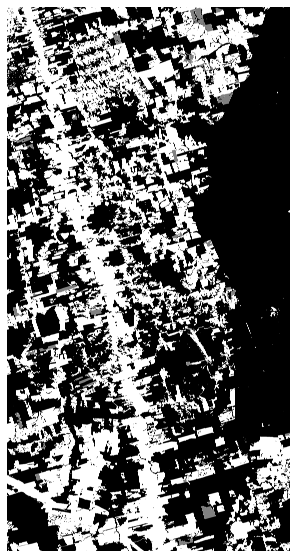

In [269]:
fig1 = plt.figure(figsize=(10,10))
plt.imshow(label_mask, cmap = plt.cm.gray)
plt.axis('off')
plt.savefig('figures/Para prediction probability.png', dpi=150, bbox_inches='tight')

In [270]:
if issubclass(type(dataset), MultipleDates):
    label_mask = np.squeeze(label_mask)

In [271]:
mean_prob.shape

(17730, 9200)

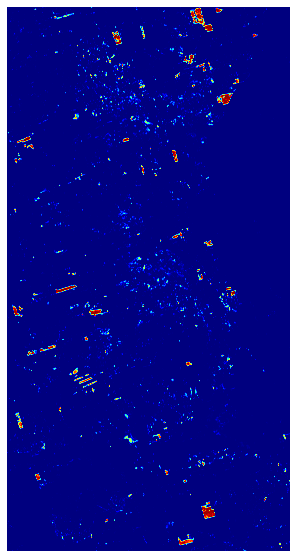

In [272]:
mean_prob = mean_prob.copy()
mean_prob[label_mask == 2] = 0
fig1 = plt.figure(figsize=(10,10))
plt.imshow(mean_prob, cmap = 'jet')
plt.axis('off')
plt.savefig('figures/Para prediction probability.png', dpi=150, bbox_inches='tight')

In [273]:
# print(np.unique(label_mask, return_counts=True))
print(label_mask.shape)

(17730, 9200)


In [274]:
label_test = label_mask[mask_amazon_ts == 1]
mean_prob_test = mean_prob[mask_amazon_ts == 1]
mean_prob_test = mean_prob_test[label_test != 2]
label_test = label_test[label_test != 2]

print(label_test.shape)
print(np.unique(label_test, return_counts=True))

(54236371,)
(array([0, 1], dtype=uint8), array([53470765,   765606], dtype=int64))


In [275]:
from sklearn import metrics
mAP = round(metrics.average_precision_score(label_test, 
        mean_prob_test)*100, 2)
print(mAP)

91.04


In [276]:
from icecream import ic

ic(prob_rec.shape)
prob_rec = np.transpose(prob_rec, (2, 0, 1))


ic| prob_rec.shape: (17760, 9216, 10)


In [277]:
prob_rec = np.expand_dims(prob_rec, axis = -1)

In [278]:
ic(prob_rec.shape)

ic| prob_rec.shape: (10, 17760, 9216, 1)


(10, 17760, 9216, 1)

In [279]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

epsilon = 1e-15
def show_im(im, ax, title = "", cmap = "jet"):
    im_plt = ax.imshow(im.astype(np.float32), cmap = cmap)
    plt.title(title)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im_plt, cax=cax) 

def get_mean(pred_probs):
      return np.mean(pred_probs, axis=0)
    
def get_uncertainty_var(pred_probs):
    return np.var(pred_probs, axis=0)
    
def predictive_variance(pred_probs):
    pred_var = get_uncertainty_var(pred_probs)
    pred_var = np.average(pred_var, axis = -1)
#    ic(pred_var.shape)
    return pred_var

def predictive_entropy(pred_probs):
    pred_mean = get_mean(pred_probs) # shape (patch_len, patch_len, class_n)
    pred_entropy = np.zeros((pred_mean.shape[0:2]))

    K = pred_mean.shape[-1]
    for k in range(K):
        pred_entropy = pred_entropy + pred_mean[..., k] * np.log(pred_mean[..., k] + epsilon) 
    pred_entropy = - pred_entropy / K
    return pred_entropy


def single_experiment_entropy(pred_prob):
    pred_entropy = np.zeros(pred_prob.shape[0:2])
    ic(pred_entropy.shape)
    
    K = pred_prob.shape[-1]
    for k in range(K):
        pred_entropy = pred_entropy + pred_prob[..., k] * np.log(pred_prob[..., k] + epsilon) 
    pred_entropy = - pred_entropy / K
    return pred_entropy

def mutual_information(pred_probs):
    H = predictive_entropy(pred_probs)
    
    # sum_entropy = 0
    sum_entropy = np.zeros(pred_probs.shape[1:-1])

    n = pred_probs.shape[0]
    K = pred_probs.shape[-1]
    ic(n, K)

    for i in range(n):
        for k in range(K):
            sum_entropy = sum_entropy + pred_probs[i, ..., k] * np.log(pred_probs[i, ..., k] + epsilon)

    sum_entropy = - sum_entropy / (n * K)

    MI = H - sum_entropy
    return MI


def expected_KL_divergence(pred_probs):
    pred_mean = get_mean(pred_probs) # shape (patch_len, patch_len, class_n)
    KL_divergence = np.zeros(pred_mean.shape[0:2])

    n = pred_probs.shape[0]
    K = pred_probs.shape[-1]

    for i in range(n):
        for k in range(K):
            # print(np.mean(pred_mean[..., k]), np.mean(pred_probs[i, ..., k]), np.mean(KL_divergence))
            # pdb.set_trace()
            KL_divergence += pred_mean[..., k] * np.log(pred_mean[..., k] / (pred_probs[i, ..., k] + epsilon) + epsilon)
    KL_divergence /= n
    return KL_divergence


In [280]:
ic(np.min(prob_rec), np.mean(prob_rec), np.max(prob_rec))
ic(prob_rec.shape)

ic| np.min(prob_rec): 0.0
    np.mean(prob_rec): 0.014945002
    np.max(prob_rec): 0.9999957
ic| prob_rec.shape: (10, 17760, 9216, 1)


(10, 17760, 9216, 1)

In [281]:
pred_entropy = predictive_entropy(prob_rec).astype(np.float32)

pred_entropy_single = single_experiment_entropy(prob_rec[0]).astype(np.float32)

pred_var = predictive_variance(prob_rec).astype(np.float32)

MI = mutual_information(prob_rec).astype(np.float32)



ic| pred_entropy.shape: (17760, 9216)
ic| n: 10, K: 1


In [282]:
KL = expected_KL_divergence(prob_rec).astype(np.float32)

In [283]:
np.mean(KL)

0.0025752722

In [284]:

pred_entropy_to_show = pred_entropy.copy()[:label_mask.shape[0], :label_mask.shape[1]]

pred_entropy_to_show[label_mask == 2] = 0


In [285]:
ic(np.min(pred_entropy_to_show), np.mean(pred_entropy_to_show), np.max(pred_entropy_to_show))
ic(np.min(pred_entropy), np.mean(pred_entropy), np.max(pred_entropy))
ic(pred_entropy.shape, pred_entropy_to_show.shape)

ic| np.min(pred_entropy_to_show): 0.0
    np.mean(pred_entropy_to_show): 0.009530488
    np.max(pred_entropy_to_show): 0.36787948
ic| np.min(pred_entropy): 5.1620966e-15
    np.mean(pred_entropy): 0.010492702
    np.max(pred_entropy): 0.36787948
ic| pred_entropy.shape: (17760, 9216)
    pred_entropy_to_show.shape: (17730, 9200)


((17760, 9216), (17730, 9200))

In [286]:
prob_rec.shape

(10, 17760, 9216, 1)

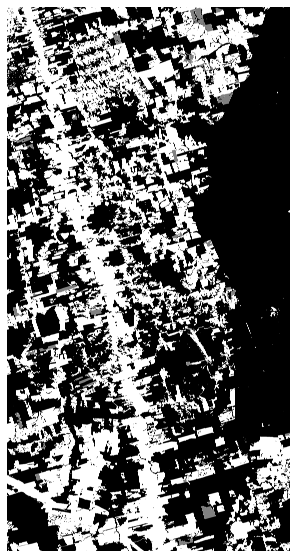

In [287]:
fig1 = plt.figure(figsize=(10,10))
plt.imshow(label_mask, cmap = plt.cm.gray)
plt.axis('off')
plt.savefig('figures/Para prediction probability.png', dpi=150, bbox_inches='tight')

In [288]:
# Computing error mask
# label_mask
'''
for idx in range(10):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(prob_rec[idx], cmap = 'jet')
# fig.savefig('figures/Para' + title_name + ' reference.png', dpi=300, bbox_inches='tight')
'''

"\nfor idx in range(10):\n    fig, ax = plt.subplots(figsize=(10,10))\n    ax.set_xticks([])\n    ax.set_yticks([])\n    ax.imshow(prob_rec[idx], cmap = 'jet')\n# fig.savefig('figures/Para' + title_name + ' reference.png', dpi=300, bbox_inches='tight')\n"

(-0.5, 9199.5, 17729.5, -0.5)

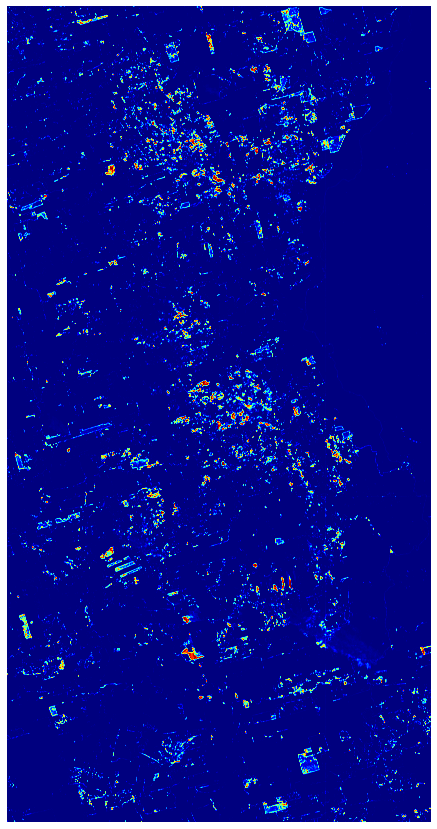

In [289]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(pred_entropy_to_show, cmap='jet')
# show_im(pred_entropy_to_show, ax, title = 'Uncertainty predictive entropy')
plt.axis('off')
#plt.savefig('figures/Para' + title_name + ' uncertainty predictive entropy.png', 
 #   dpi=150, bbox_inches='tight')

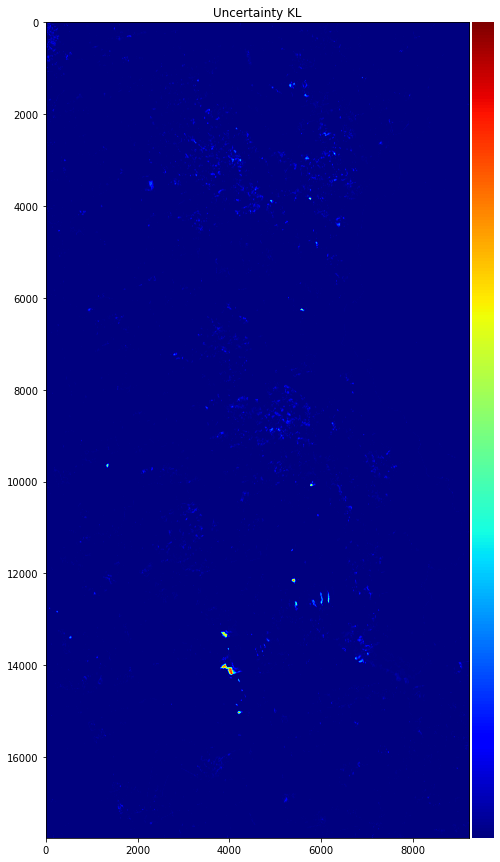

In [290]:
fig, ax = plt.subplots(1,1,figsize=(15,15))
show_im(KL, ax, title = 'Uncertainty KL')
plt.axis('off')
plt.savefig('figures/Para' + title_name + ' uncertainty KL.png', 
    dpi=150, bbox_inches='tight')

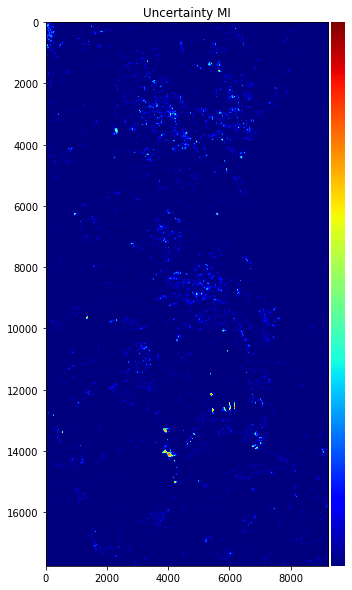

In [291]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(MI, ax, title = 'Uncertainty MI')
plt.axis('off')
plt.savefig('figures/Para' + title_name + ' uncertainty MI.png', 
    dpi=150, bbox_inches='tight')

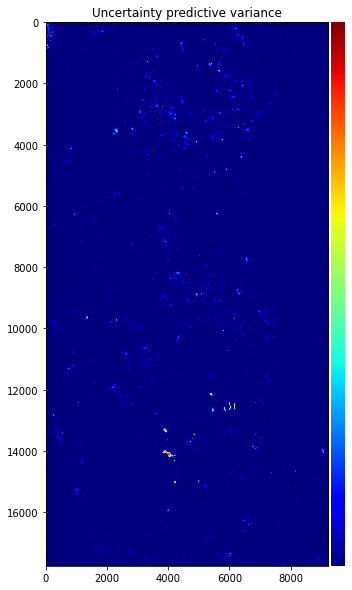

In [292]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(pred_var, ax, title = 'Uncertainty predictive variance')
plt.axis('off')
plt.savefig('figures/Para' + title_name + ' uncertainty Predictive variance.png', 
    dpi=150, bbox_inches='tight')

In [293]:
ic(pred_entropy.shape)


ic| pred_entropy.shape: (17760, 9216)


(17760, 9216)

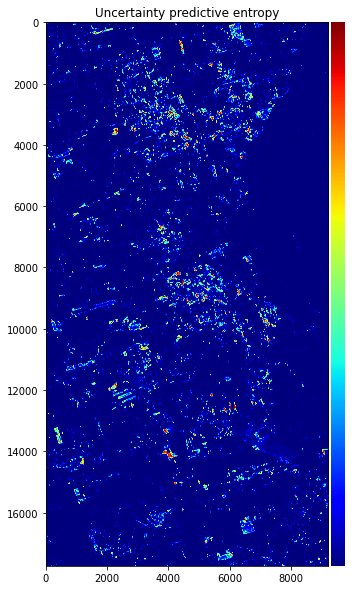

In [294]:

# pred_entropy_to_show = pred_entropy[:label_mask.shape[0], :label_mask.shape[1]].copy()

# ic(np.min(pred_entropy_to_show), np.mean(pred_entropy_to_show), np.max(pred_entropy_to_show))

# pred_entropy_to_show[label_mask == 2] = 0
fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(pred_entropy_to_show, ax, title = 'Uncertainty predictive entropy')
plt.axis('off')
plt.savefig('figures/Para' + title_name + ' uncertainty predictive entropy.png', 
    dpi=150, bbox_inches='tight')

In [295]:
ic(prob_rec.shape)
ic(np.min(prob_rec), np.mean(prob_rec), np.max(prob_rec))


ic| prob_rec.shape: (10, 17760, 9216, 1)
ic| np.min(prob_rec): 0.0
    np.mean(prob_rec): 0.014945002
    np.max(prob_rec): 0.9999957


(0.0, 0.014945002, 0.9999957)

In [296]:


'''
fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(pred_entropy_single, ax, title = 'Uncertainty predictive entropy single sample')
'''


"\nfig, ax = plt.subplots(1,1,figsize=(10,10))\nshow_im(pred_entropy_single, ax, title = 'Uncertainty predictive entropy single sample')\n"

In [297]:

'''
MI = mutual_information(prob_rec)

fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(MI, ax, title = 'Uncertainty MI')
'''


"\nMI = mutual_information(prob_rec)\n\nfig, ax = plt.subplots(1,1,figsize=(10,10))\nshow_im(MI, ax, title = 'Uncertainty MI')\n"

(array([0, 1, 2], dtype=uint8), array([81558000, 65246400, 16311600], dtype=int64))


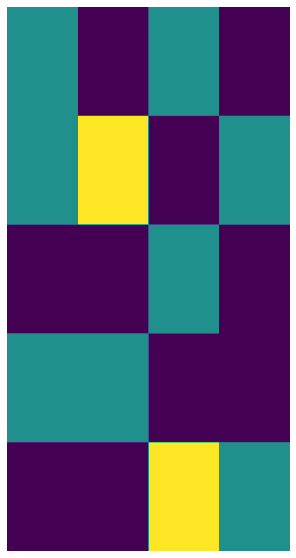

In [298]:
# mask_tr_val = test 0, train 1, val 2. 
# mask_ts = test 1.
print(np.unique(mask_tr_val, return_counts=True))
plt.figure(figsize=(10,10))
plt.imshow(mask_tr_val)
plt.axis('off')
plt.savefig('figures/Train val mask.png', dpi=200, bbox_inches='tight')



In [299]:
label_mask_current_deforestation = label_mask.copy()
label_mask_current_deforestation[label_mask_current_deforestation==2] = 0

In [300]:
label_mask_current_deforestation_to_show = label_mask_current_deforestation.copy()
label_mask_current_deforestation_to_show = np.abs(
        label_mask_current_deforestation_to_show - 1)
ic(np.unique(label_mask_current_deforestation_to_show, return_counts=True))

ic| np.unique(label_mask_current_deforestation_to_show, return_counts=True): (array([  0, 255], dtype=uint8), array([  1838508, 161277492], dtype=int64))


(array([  0, 255], dtype=uint8), array([  1838508, 161277492], dtype=int64))

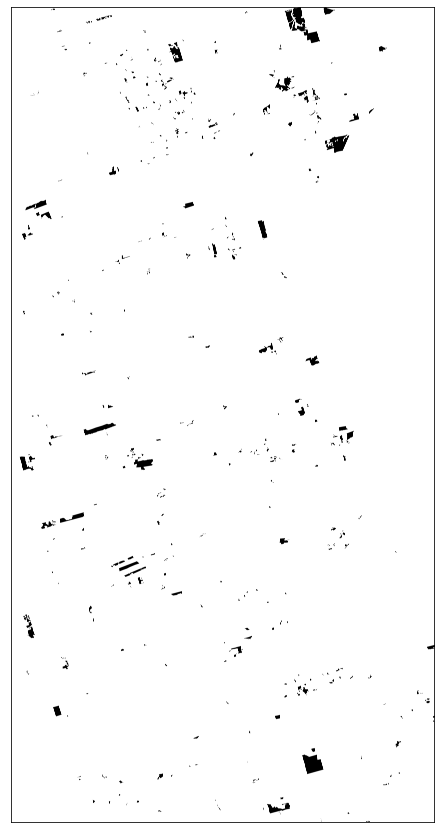

In [301]:
# Computing error mask
# label_mask

fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(label_mask_current_deforestation_to_show, cmap = plt.cm.gray)
fig.savefig('figures/Para' + title_name + ' reference.png', dpi=300, bbox_inches='tight')




In [302]:


label_mask_val = label_mask[mask_tr_val == 2]
ic(label_mask_val.shape)

mean_prob_val = mean_prob[mask_tr_val == 2]

mean_prob_val = mean_prob_val[label_mask_val != 2]
label_mask_val_valid = label_mask_val[label_mask_val != 2]
ic(label_mask_val_valid.shape)



ic| label_mask_val.shape: (16311600,)
ic| label_mask_val_valid.shape: (9450701,)


(9450701,)

In [303]:
from sklearn import metrics
pos_label = 1
precision, recall, thresholds = metrics.precision_recall_curve(
            label_mask_val_valid, mean_prob_val, pos_label=pos_label)



In [304]:
fscore = (2 * precision * recall) / (precision + recall)
ix = np.nanargmax(fscore)
best_threshold = thresholds[ix]
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.581732, F-Score=0.855


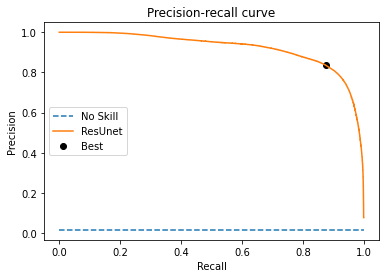

In [305]:
importlib.reload(_metrics)
_metrics.plotPrecisionRecall(label_mask_val, precision, recall, ix)
plt.savefig('figures/' + 'Para_prediction_recall_curve.png', dpi=150, bbox_inches='tight')

In [306]:
print(mean_prob.shape)
predicted = np.zeros_like(mean_prob)
threshold = 0.5

if predictor != Predictor.pred_entropy_single:
    predicted[mean_prob>=threshold] = 1
    predicted[mean_prob<threshold] = 0
else:
    print("Single entropy")
    predicted[prob_rec[0][...,-1][:label_mask.shape[0], :label_mask.shape[1]]>=threshold] = 1
    predicted[prob_rec[0][...,-1][:label_mask.shape[0], :label_mask.shape[1]]<threshold] = 0

print(np.unique(predicted, return_counts=True))

predicted_unpad = predicted.copy()
predicted_unpad[label_mask == 2] = 0
ic(predicted_unpad.shape, predicted.shape)
del predicted

(17730, 9200)
(array([0., 1.], dtype=float32), array([161192339,   1923661], dtype=int64))


ic| predicted_unpad.shape: (17730, 9200)
    predicted.shape: (17730, 9200)


In [307]:
threshold

0.5

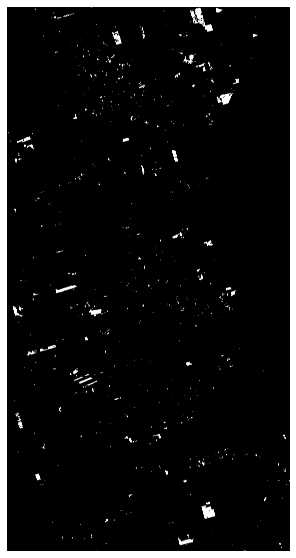

In [308]:

plt.figure(figsize=(10,10))
plt.imshow(predicted_unpad, cmap = plt.cm.gray)
plt.axis('off')
plt.savefig('figures/Para' + title_name + ' predicted.png', dpi=150, bbox_inches='tight')


In [309]:

# mean_prob_unpad = mean_prob[:-npad[0][1], :-npad[1][1]]

In [310]:
# mean_prob_unpad.shape

In [311]:
# ic(mask_amazon_ts.shape)
# mask_amazon_ts = mask_amazon_ts[:-npad[0][1], :-npad[1][1]]


In [312]:
# ic(mask_amazon_ts.shape, predicted_unpad.shape)
# label_mask_current_deforestation = label_mask_current_deforestation[:-npad[0][1], :-npad[1][1]]

In [313]:
# label_mask = label_mask[:-npad[0][1], :-npad[1][1]]

In [314]:
import importlib
import utils_v1
importlib.reload(utils_v1)

<module 'utils_v1' from 'd:\\Jorge\\deforestation_uncertainty\\utils_v1.py'>

In [315]:
ic(predicted_unpad.shape, label_mask_current_deforestation.shape,
    mask_amazon_ts.shape, label_mask.shape, mean_prob.shape)

ic| predicted_unpad.shape: (17730, 9200)
    label_mask_current_deforestation.shape: (17730, 9200)
    mask_amazon_ts.shape: (17730, 9200)
    label_mask.shape: (17730, 9200)
    mean_prob.shape: (17730, 9200)


((17730, 9200), (17730, 9200), (17730, 9200), (17730, 9200), (17730, 9200))

In [316]:
# test metrics
from sklearn.metrics import f1_score

predicted_test = predicted_unpad[mask_amazon_ts == 1]
label_mask_current_deforestation_test = label_mask_current_deforestation[mask_amazon_ts == 1]
label_mask_test = label_mask[mask_amazon_ts == 1]
mean_prob_test = mean_prob[mask_amazon_ts == 1]

ic(predicted_test.shape)

predicted_test = utils_v1.excludeBackgroundAreasFromTest(
        predicted_test, label_mask_test)
label_mask_current_deforestation_test = utils_v1.excludeBackgroundAreasFromTest(
        label_mask_current_deforestation_test, label_mask_test)
mean_prob_test = utils_v1.excludeBackgroundAreasFromTest(
        mean_prob_test, label_mask_test)

ic(predicted_test.shape)


ic| predicted_test.shape: (81558000,)
ic| predicted_test.shape: (54236371,)


(54236371,)

In [317]:
importlib.reload(_metrics)
removePolygons = True
if removePolygons == True:
    # remove polygons smaller than 625 px
    min_polygon_area = 625 # pixels

    predicted_unpad, label_mask = _metrics.removeSmallPolygonsForMetrics(predicted_unpad, label_mask,
        min_polygon_area)
    predicted_masked, label_masked = _metrics.getTest(predicted_unpad, label_mask, mask_amazon_ts)

    predicted_test = predicted_masked
    label_mask_current_deforestation_test = label_masked


ic| np.unique(predicted, return_counts=True): (array([0., 1.], dtype=float32), array([161192339,   1923661], dtype=int64))
    np.unique(predicted_larger_than_min_area, return_counts=True): (array([0., 1.], dtype=float32), array([161368428,   1747572], dtype=int64))
ic| np.unique(ignored_polygons, return_counts=True): (array([0., 1.], dtype=float32), array([162939911,    176089], dtype=int64))
ic| predicted.shape: (17730, 9200), label_mask.shape: (17730, 9200)
ic| predicted_masked.shape: (81558000,)
    label_masked.shape: (81558000,)
ic| np.unique(label_masked, return_counts=True): (array([0, 1, 2], dtype=uint8),
                                                  array([53412879,   734235, 27410886], dtype=int64))
ic| predicted_masked.shape: (54147114,)
    label_masked.shape: (54147114,)


In [318]:

deforestationMetricsGet = True
if deforestationMetricsGet == True:
        f1 = round(f1_score(label_mask_current_deforestation_test, predicted_test)*100, 2)
        precision = round(precision_score(label_mask_current_deforestation_test, predicted_test)*100, 2)
        recall = round(recall_score(label_mask_current_deforestation_test, predicted_test)*100, 2)
        oa = round(accuracy_score(label_mask_current_deforestation_test, predicted_test)*100, 2)
        if removePolygons == False:
                mAP = round(metrics.average_precision_score(label_mask_current_deforestation_test, 
                        mean_prob_test)*100, 2)
        else:
                '''
                # Computing metrics over the test tiles
                # mean_prob = mean_prob[:label_mask.shape[0], :label_mask.shape[1]]
                ref1 = np.ones_like(label_mask).astype(np.float32)

                ref1 [label_mask == 2] = 0
                TileMask = mask_amazon_ts * ref1
                GTTruePositives = label_mask==1

                # Metrics for th=0.5    

                Npoints = 50
                Pmax = np.max(mean_prob[GTTruePositives * TileMask ==1])
                ProbList = np.linspace(Pmax,0,Npoints)

                metrics_ = matrics_AA_recall(ProbList, mean_prob, label_mask, mask_amazon_ts, 625)
                print('Metrics th = 0.5: ', metrics_*100)
                '''
                pass


In [319]:
ic(f1, precision, recall)
# ic(f1, precision, recall)


ic| f1: 85.77, precision: 88.45, recall: 83.24


(85.77, 88.45, 83.24)

In [320]:
ic(oa)

ic| oa: 99.63


99.63

### Metrics for validation set in forest/deforestation detection

In [321]:
ic(mask_tr_val.shape)

ic| mask_tr_val.shape: (17730, 9200)


(17730, 9200)

In [322]:
predicted_val = predicted_unpad[mask_tr_val == 2]
predicted_val = predicted_val[label_mask_val != 2]

In [323]:

f1_val = round(f1_score(label_mask_val_valid, predicted_val)*100, 2)
precision_val = round(precision_score(label_mask_val_valid, predicted_val)*100, 2)
recall_val = round(recall_score(label_mask_val_valid, predicted_val)*100, 2)

mAP_val = round(metrics.average_precision_score(label_mask_val_valid, mean_prob_val)*100, 2)


ic(f1_val, precision_val, recall_val, mAP_val)

ic| f1_val: 86.14
    precision_val: 84.03
    recall_val: 88.36
    mAP_val: 92.17


(86.14, 84.03, 88.36, 92.17)

In [324]:
calculateMAPWithoutSmallPolygons = False
if calculateMAPWithoutSmallPolygons == True:
    # Computing metrics over the test tiles
    # mean_prob = mean_prob[:label_mask.shape[0], :label_mask.shape[1]]
    ref1 = np.ones_like(label_mask).astype(np.uint8)

    ref1 [label_mask == 2] = 0
    TileMask = mask_amazon_ts * ref1
    GTTruePositives = label_mask==1

    # Metrics for th=0.5    

    ProbList_05 = [0.5]

    metrics_05 = matrics_AA_recall(ProbList_05, mean_prob, label_mask, mask_amazon_ts, 625)
    print('Metrics th = 0.5: ', metrics_05*100)


In [325]:

error_mask = np.abs(predicted_unpad - label_mask_current_deforestation)
print(np.unique(error_mask, return_counts=True))


(array([0., 1.], dtype=float32), array([162560284,    555716], dtype=int64))


In [326]:
false_positive_mask = predicted_unpad - label_mask_current_deforestation
ic(false_positive_mask.shape)
ic(np.unique(false_positive_mask, return_counts=True))
# 0 class 0, 1 class 1, 2 false positive, 3 false negative
# colormap black, white, blue, red.



ic| false_positive_mask.shape: (17730, 9200)
ic| np.unique(false_positive_mask, return_counts=True): (array([-1.,  0.,  1.], dtype=float32),
                                                         array([   323326, 162560284,    232390], dtype=int64))


(array([-1.,  0.,  1.], dtype=float32),
 array([   323326, 162560284,    232390], dtype=int64))

In [327]:
ic(predicted_unpad.shape, label_mask.shape)

ic| predicted_unpad.shape: (17730, 9200)
    label_mask.shape: (17730, 9200)


((17730, 9200), (17730, 9200))

In [328]:

importlib.reload(_metrics)

prediced_unpad_to_show = predicted_unpad.copy()
prediced_unpad_to_show[label_mask == 2] = 0

error_mask_to_show = _metrics.getRgbErrorMask(prediced_unpad_to_show, 
        label_mask_current_deforestation).astype(np.uint8)
error_mask_to_show_rgb = _metrics.saveRgbErrorMask(error_mask_to_show).astype(np.uint8)
del error_mask_to_show
cv2.imwrite('figures/Para_error_mask_to_show_rgb.png', error_mask_to_show_rgb)

# ,
#        dim = (617, 1162)


True

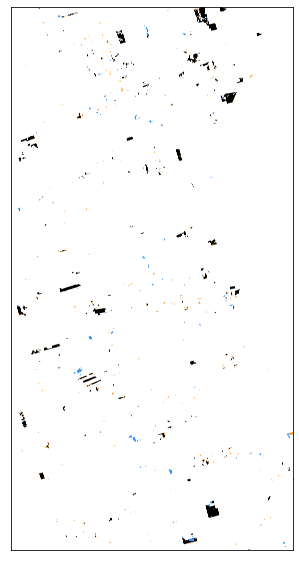

In [329]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xticks([])
ax.set_yticks([])

ax.imshow(error_mask_to_show_rgb[...,::-1])

fig.savefig('figures/Para' + title_name + ' error mask color.png', dpi=300, bbox_inches='tight')


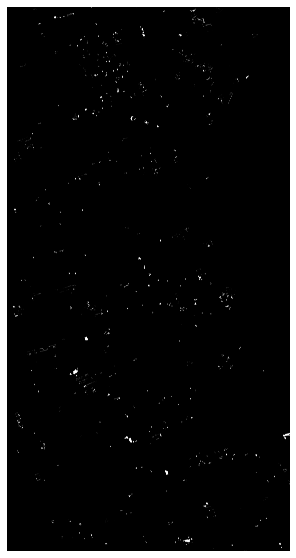

In [330]:
plt.figure(figsize=(10,10))
plt.imshow(error_mask, cmap=plt.cm.gray)
title_name = 'ResUnet'
plt.axis('off')
plt.savefig('figures/Para' + title_name + ' error mask.png', dpi=150, bbox_inches='tight')

In [331]:
ic(label_mask.shape)
ic(mask_amazon_ts.shape)
 
label_mask_test = utils_v1.getTestVectorFromIm(
        label_mask, mask_amazon_ts)        
ic(label_mask_test.shape)

error_mask_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
        error_mask, mask_amazon_ts),
        label_mask_test) 


error_mask_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
        error_mask, mask_tr_val, mask_return_value = 2),
        label_mask_val) 

 
ic(error_mask_test.shape)

ic| label_mask.shape: (17730, 9200)
ic| mask_amazon_ts.shape: (17730, 9200)
ic| label_mask_test.shape: (81558000,)
ic| error_mask_test.shape: (54147114,)


(54147114,)

In [332]:
# ic(pred_entropy[:-npad[0][1], :-npad[1][1]][:-npad[0][1], :-npad[1][1]].shape)

In [333]:
     

ic(pred_entropy.shape, utils_v1.unpadIm(pred_entropy, npad).shape, 
    mask_amazon_ts.shape, label_mask_test.shape)
pred_entropy_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy, npad), mask_amazon_ts),
        label_mask_test)
  
pred_var_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_var, npad), mask_amazon_ts),
        label_mask_test)

MI_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(MI, npad), mask_amazon_ts),
        label_mask_test)

KL_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(KL, npad), mask_amazon_ts),
        label_mask_test)


ic| pred_entropy.shape: (17760, 9216)
    utils_v1.unpadIm(pred_entropy, npad).shape: (17730, 9200)
    mask_amazon_ts.shape: (17730, 9200)
    label_mask_test.shape: (81558000,)


In [334]:
pred_entropy_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy, npad), mask_tr_val, mask_return_value = 2),
        label_mask_val)

pred_var_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_var, npad), mask_tr_val, mask_return_value = 2),
        label_mask_val)

MI_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(MI, npad), mask_tr_val, mask_return_value = 2),
        label_mask_val)

KL_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(KL, npad), mask_tr_val, mask_return_value = 2),
        label_mask_val)


In [335]:
pred_entropy_single_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy_single, npad), mask_amazon_ts),
        label_mask_test)

pred_entropy_single_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy_single, npad), mask_tr_val, mask_return_value = 2),
        label_mask_val)

        

In [336]:
# dataset.previewLims1 = np.array([2200, 3200, 6900, 7900])
# dataset.previewLims2 = np.array([500, 1500, 3500, 4500])
# dataset.previewBands = [2, 1, 0] 

In [337]:


# dataset.previewLims1 = np.array([7600, 8600, 4500, 5500])
# dataset.previewLims1 = np.array([12200, 13200, 200, 1200])
# dataset.previewLims1 = np.array([11800, 12800, 9000, 10000])

# dataset.previewLims1 = np.array([11500, 12500, 9000, 10000])

# dataset.previewLims2 = np.array([5000, 6000, 9500, 10500])

ic(dataset.previewLims1, dataset.previewLims2)
lims = dataset.previewLims1
ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True))
lims = dataset.previewLims2
ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]))
ic(mask_amazon_ts.shape)


ic| dataset.previewLims1: array([2200, 3200, 6900, 7900])
    dataset.previewLims2: array([ 500, 1500, 3500, 4500])
ic| np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([1000000], dtype=int64))
ic| np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| mask_amazon_ts.shape: (17730, 9200)


(17730, 9200)

In [338]:
uncertainty_vlims = [np.min(pred_entropy_to_show), np.max(pred_entropy_to_show)]


ic| dataset.previewLims1: array([2200, 3200, 6900, 7900])
    dataset.previewLims2: array([ 500, 1500, 3500, 4500])
ic| np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([1000000], dtype=int64))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


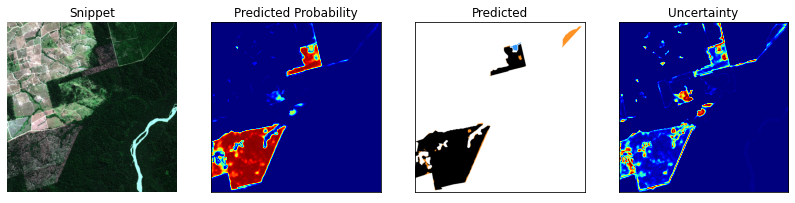

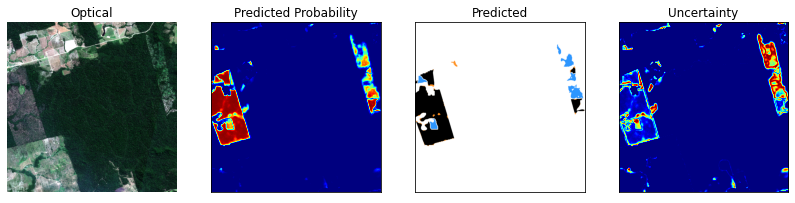

In [339]:


plotCropSampleFlag = True
if plotCropSampleFlag == True:
        importlib.reload(_metrics)
        # import matplotlib
        # customCmap = matplotlib.colors.ListedColormap(['black', 'red'])
        ic(dataset.previewLims1, dataset.previewLims2)
        lims = dataset.previewLims1
        ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]))
        lims = dataset.previewLims2
        ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True))

        _plt.plotCropSample4(image_stack[...,dataset.previewBands], mean_prob, 
                error_mask_to_show_rgb[...,::-1], pred_entropy_to_show, 
                lims = dataset.previewLims1, 
                titles = ['Snippet', 'Predicted Probability', 'Predicted', 'Uncertainty'],
                cmaps = [plt.cm.gray, 'jet', plt.cm.gray, 'jet'],
                maskBackground = [False, True, False, True],
                invertMask = [False, False, False, False], uncertainty_vlims = uncertainty_vlims)
        plt.savefig('figures/' + dataset.__class__.__name__ + 'PredictSampleUncertainty1.png', dpi=150, bbox_inches='tight')

        _plt.plotCropSample4(image_stack[...,dataset.previewBands], mean_prob, 
                error_mask_to_show_rgb[...,::-1], pred_entropy_to_show, 
                lims = dataset.previewLims2, 
                titles = ['Optical', 'Predicted Probability', 'Predicted', 'Uncertainty'],
                cmaps = [plt.cm.gray, 'jet', plt.cm.gray, 'jet'],
                maskBackground = [False, True, False, True],
                invertMask = [False, False, False, False], uncertainty_vlims = uncertainty_vlims)
        plt.savefig('figures/' + dataset.__class__.__name__ + 'PredictSampleUncertainty2.png', dpi=150, bbox_inches='tight')

In [340]:

if predictor == Predictor.pred_var:
    uncertainty = pred_var_test
    uncertainty_val = pred_var_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Variance'
    best_threshold = 0.2
elif predictor == Predictor.MI:
    uncertainty = MI_test
    uncertainty_val = MI_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Mutual Information'
    best_threshold = 0.2
elif predictor == Predictor.pred_entropy:
    uncertainty = pred_entropy_test
    uncertainty_val = pred_entropy_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Entropy'
    best_threshold = 0.287
elif predictor == Predictor.KL:
    uncertainty = KL_test
    uncertainty_val = KL_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Entropy'
    best_threshold = 0.287

elif predictor == Predictor.pred_entropy_single:
    uncertainty = pred_entropy_single_test
    uncertainty_val = pred_entropy_single_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Entropy Single'
    best_threshold = 0.287


In [341]:
ic(np.min(uncertainty), np.mean(uncertainty), np.max(uncertainty))
ic(np.min(pred_entropy), np.mean(pred_entropy), np.max(pred_entropy))


ic| np.min(uncertainty): 1.15577e-09
    np.mean(uncertainty): 0.012612292
    np.max(uncertainty): 0.36787948
ic| np.min(pred_entropy): 5.1620966e-15
    np.mean(pred_entropy): 0.010492702
    np.max(pred_entropy): 0.36787948


(5.1620966e-15, 0.010492702, 0.36787948)

In [342]:

y_test = error_mask_test
y_val = error_mask_val

ic(y_test.shape, uncertainty.shape)
pos_label = 1
ROCmode = 'val'
if ROCmode == 'test':
    fpr, tpr, thresholds = metrics.roc_curve(y_test, uncertainty, pos_label=pos_label)
elif ROCmode == 'val':
    fpr, tpr, thresholds = metrics.roc_curve(y_val, uncertainty_val, pos_label=pos_label)

roc_auc = metrics.auc(fpr, tpr)
ic(roc_auc)

ic| y_test.shape: (54147114,), uncertainty.shape: (54147114,)
ic| roc_auc: 0.9696066346814383


0.9696066346814383

Best Threshold=0.032234, G-Mean=0.942


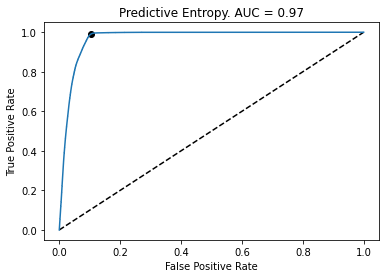

In [343]:
importlib.reload(_metrics)
plt.figure()
_metrics.plotAUC(fpr, tpr, roc_auc, modelId = title_name)
ix, best_threshold_uncertainty = _metrics.getBestThresholdGMean(fpr, tpr, thresholds)
# ix, best_threshold_uncertainty = _metrics.getBestThresholdJStatistic(fpr, tpr, thresholds)

_metrics.plotBestThreshold(fpr, tpr, ix)
plt.savefig(figures_path + title_name + ' roc_curve.png', dpi=200)

In [344]:
np.set_printoptions(suppress=False)
ic(best_threshold_uncertainty)
np.set_printoptions(suppress=True)


ic| best_threshold_uncertainty: 0.032234337


In [345]:
# best_threshold_uncertainty = 0.262948
# best_threshold_uncertainty = 0.08329400420188904

In [346]:
# threshold = 0.003254
y_pred_thresholded = np.zeros_like(uncertainty)
y_pred_thresholded[uncertainty >= best_threshold_uncertainty] = 1


In [347]:
metrics_error_detection = False
if metrics_error_detection == True:
    f1 = round(f1_score(error_mask_test, y_pred_thresholded)*100, 2)
    precision = round(metrics.precision_score(error_mask_test, y_pred_thresholded)*100, 2)
    recall = round(metrics.recall_score(error_mask_test, y_pred_thresholded)*100, 2)
    ic(f1, precision, recall)

    cm = metrics.confusion_matrix(error_mask_test, y_pred_thresholded)
    print(cm)

In [348]:
if metrics_error_detection == True:

    ic(best_threshold_uncertainty)

In [349]:
if metrics_error_detection == True:

    predicted_error_mask = np.zeros(pred_entropy.shape, dtype = np.uint8)
    predicted_error_mask[pred_entropy>=best_threshold_uncertainty] = 1
    predicted_error_mask = utils_v1.unpadIm(predicted_error_mask, npad)

    predicted_error_mask[label_mask == 2] = 0

In [350]:
if metrics_error_detection == True:

    # ic(np.unique(predicted_error_mask, return_counts=True))
    # ic(np.unique(error_mask, return_counts=True))
    predicted_error_mask_to_show = predicted_error_mask.copy()
    predicted_error_mask_to_show = np.abs(1 - predicted_error_mask_to_show)
    predicted_error_mask_to_show = predicted_error_mask_to_show.astype(np.uint8)*255
    predicted_error_mask_to_show = np.repeat(
        np.expand_dims(predicted_error_mask_to_show, axis=-1),
        3, axis = -1)
    fig, ax = plt.subplots(figsize=(15,15))
    ax.set_xticks([])
    ax.set_yticks([])

    ax.imshow(predicted_error_mask_to_show)


    title_name = 'ResUnet'
    fig.savefig('figures/Para' + title_name + 'predicted error mask.png', dpi=300, bbox_inches='tight')


In [351]:
if metrics_error_detection == True:

    predicted_error_mask_forest = predicted_error_mask.copy()
    predicted_error_mask_forest[predicted_unpad == 1] = 0
    ic(np.unique(predicted_unpad, return_counts=True))
    ic(np.unique(predicted_error_mask_forest, return_counts=True))

    plt.figure(figsize=(10,10))
    plt.imshow(predicted_error_mask, cmap=plt.cm.gray)
    title_name = 'ResUnet'
    plt.axis('off')
    plt.savefig('figures/Para' + title_name + 'predicted error mask forest.png', dpi=150, bbox_inches='tight')


In [352]:
if metrics_error_detection == True:

        importlib.reload(_metrics)
        _metrics.plotConfusionMatrix(cm)
        plt.savefig(figures_path + title_name + ' confusion matrix ROC threshold.png', 
                dpi=200, bbox_inches='tight')

In [353]:
label_mask_current_deforestation_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                label_mask_current_deforestation, mask_amazon_ts),
        label_mask_test)

predicted_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                predicted_unpad, mask_amazon_ts),
        label_mask_test)
        


Get precision-recall threshold

In [354]:
precision, recall, thresholds = metrics.precision_recall_curve(
            y_val, uncertainty_val, pos_label=pos_label)



In [355]:
ic(thresholds)

ic| thresholds: array([0.00008793, 0.00008793, 0.00008793, ..., 0.36787942, 0.36787945,
                       0.36787948], dtype=float32)


array([0.00008793, 0.00008793, 0.00008793, ..., 0.36787942, 0.36787945,
       0.36787948], dtype=float32)

In [356]:
fscore = (2 * precision * recall) / (precision + recall)
ix = np.nanargmax(fscore)
best_threshold_uncertainty = thresholds[ix]
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.268753, F-Score=0.237


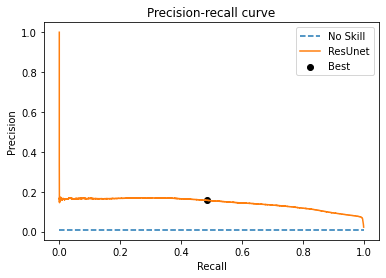

In [357]:
importlib.reload(_metrics)
_metrics.plotPrecisionRecall(y_val, precision, recall, ix)
plt.savefig('figures/' + 'Para' + 'prediction_recall_curve.png', dpi=150, bbox_inches='tight')

In [358]:
'''
# Metrics for th=0.5    
ProbList_05 = [0.5]

metrics_05 = matrics_AA_recall(ProbList_05, mean_prob, label_mask, mask_amazon_ts, 625)
print('Metrics th = 0.5: ', metrics_05*100)
'''


"\n# Metrics for th=0.5    \nProbList_05 = [0.5]\n\nmetrics_05 = matrics_AA_recall(ProbList_05, mean_prob, label_mask, mask_amazon_ts, 625)\nprint('Metrics th = 0.5: ', metrics_05*100)\n"

In [359]:
ic(np.min(uncertainty), np.average(uncertainty), np.max(uncertainty))

ic| np.min(uncertainty): 1.15577e-09
    np.average(uncertainty): 0.012612292
    np.max(uncertainty): 0.36787948


(1.15577e-09, 0.012612292, 0.36787948)

In [360]:
# plt.hist(uncertainty)

In [361]:
ic(uncertainty.dtype, label_mask_current_deforestation_test.dtype, predicted_test.dtype)

ic| uncertainty.dtype: dtype('float32')
    label_mask_current_deforestation_test.dtype: dtype('uint8')
    predicted_test.dtype: dtype('float32')


(dtype('float32'), dtype('uint8'), dtype('float32'))

In [362]:
ic(uncertainty.shape, label_mask_current_deforestation_test.shape)
ic(np.unique(label_mask_current_deforestation_test))

ic| uncertainty.shape: (54147114,)
    label_mask_current_deforestation_test.shape: (54147114,)
ic| np.unique(label_mask_current_deforestation_test): array([0, 1], dtype=uint8)


array([0, 1], dtype=uint8)

In [363]:
ic(np.min(uncertainty), np.mean(uncertainty), np.max(uncertainty))

ic| np.min(uncertainty): 1.15577e-09
    np.mean(uncertainty): 0.012612292
    np.max(uncertainty): 0.36787948


(1.15577e-09, 0.012612292, 0.36787948)

In [364]:
importlib.reload(_metrics)

threshold_uncertainty = 0.15

predicted_thresholded = np.zeros_like(uncertainty).astype(np.int8)
predicted_thresholded[uncertainty >= threshold_uncertainty] = 1
predicted_thresholded = predicted_thresholded.astype(np.uint8)
ic(predicted_thresholded.shape)


ic| predicted_thresholded.shape: (54147114,)


(54147114,)

In [365]:
ic(np.unique(predicted_thresholded, return_counts=True),
    np.unique(label_mask, return_counts=True),
    np.unique(mask_amazon_ts, return_counts=True))



ic| np.unique(predicted_thresholded, return_counts=True): (array([0, 1], dtype=uint8), array([52405312,  1741802], dtype=int64))
    np.unique(label_mask, return_counts=True): (array([0, 1, 2], dtype=uint8),
                                                array([100786493,   1779524,  60549983], dtype=int64))
    np.unique(mask_amazon_ts, return_counts=True): (array([0, 1], dtype=uint8), array([81558000, 81558000], dtype=int64))


((array([0, 1], dtype=uint8), array([52405312,  1741802], dtype=int64)),
 (array([0, 1, 2], dtype=uint8),
  array([100786493,   1779524,  60549983], dtype=int64)),
 (array([0, 1], dtype=uint8), array([81558000, 81558000], dtype=int64)))

In [366]:
def getUncertaintyPercentageFromTest(uncertainty_mask, 
        label_mask, mask_test):
    total_test_area = mask_test.copy()
    total_test_area[label_mask == 2] = 0

    percentage = np.count_nonzero(uncertainty_mask.flatten()) / np.count_nonzero(total_test_area.flatten())
    return total_test_area, percentage

total_test_area, percentage = getUncertaintyPercentageFromTest(predicted_thresholded, 
        label_mask, mask_amazon_ts)

ic(percentage)

ic| percentage: 0.032167956356824484


0.032167956356824484

In [367]:
AA = np.count_nonzero(predicted_thresholded.flatten()) / len(label_mask_current_deforestation_test)
ic(AA)

# metrics_values = _metrics.getAA_Recall(uncertainty, 
#                 label_mask_current_deforestation_test, 
#                 predicted_test, [threshold_uncertainty])


ic| AA: 0.032167956356824484


0.032167956356824484

In [368]:
predictor

<Predictor.pred_entropy: 3>

In [369]:

importlib.reload(_metrics)

# threshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]

# threshold_list = [0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36, np.max(uncertainty)-0.003]
if predictor == Predictor.pred_entropy:
        threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                0.25, 0.27, 0.3, 0.34, 0.36, np.max(uncertainty)-0.003, np.max(uncertainty)-0.0015]
elif predictor == Predictor.pred_var:
        threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                0.25, 0.27, 0.3, 0.34, 0.36]
        threshold_list = [x*0.13/0.36 for x in threshold_list] + [np.max(uncertainty)-0.0015, np.max(uncertainty)-0.0008]
elif predictor == Predictor.MI:
        threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                0.25, 0.27, 0.3, 0.34, 0.36]
        threshold_list = [x*0.235/0.36 for x in threshold_list] + [np.max(uncertainty)-0.003, np.max(uncertainty)-0.0015]
elif predictor == Predictor.KL:
        threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                0.25, 0.27, 0.3, 0.34, 0.36]
        threshold_list = [x*1.0/0.36 for x in threshold_list] + [np.max(uncertainty)-0.006, np.max(uncertainty)-0.003]
                
        # threshold_list = np.linspace(np.min(uncertainty) + 0.0015, np.max(uncertainty) - 0.0015, 19)
print(threshold_list)
loadThresholdMetrics = False
if loadThresholdMetrics == False:
        # threshold_list = [0.1]
        # y_test
        ic(uncertainty.shape, label_mask_current_deforestation_test.shape)
        importlib.reload(_metrics)

        metrics_values = _metrics.getAA_Recall(uncertainty, 
                label_mask_current_deforestation_test, 
                predicted_test, threshold_list)

        # ic(metrics_values)


ic| uncertainty.shape: (54147114,)
    label_mask_current_deforestation_test.shape: (54147114,)


[0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 0.25, 0.27, 0.3, 0.34, 0.36, 0.3648794801235199, 0.3663794801235199]
threshold 0.0025
(45715287,) (45715287,)


ic| label_current_deforestation_test_classified_incorrect.shape: (8431827,)
    predicted_test_classified_incorrect.shape: (8431827,)


cm_correct [[45710012        0]
 [    5275        0]]


d:\Jorge\deforestation_uncertainty\src\metrics.py:296: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_L = TP_L / (TP_L + FP_L)
ic| TP_H + FN_H + FP_H + TN_H: 8431827
    len(label_mask_current_deforestation_test): 54147114
ic| TP_H + FN_H + FP_H + TN_H: 8431827
    len(label_mask_current_deforestation_test): 54147114


cm_incorrect [[7623052   79815]
 [ 117754  611206]]
[       nan 0.         0.         0.15572071 0.884497   0.83846302]
threshold 0.005
(47176944,) (47176944,)


ic| label_current_deforestation_test_classified_incorrect.shape: (6970170,)
    predicted_test_classified_incorrect.shape: (6970170,)


cm_correct [[47170389        0]
 [    6346      209]]


ic| TP_H + FN_H + FP_H + TN_H: 6970170
    len(label_mask_current_deforestation_test): 54147114
ic| TP_H + FN_H + FP_H + TN_H: 6970170
    len(label_mask_current_deforestation_test): 54147114


cm_incorrect [[6162675   79815]
 [ 116683  610997]]
[1.         0.03188406 0.00028465 0.12872653 0.88446205 0.83965067]
threshold 0.0075
(48039236,) (48039236,)


ic| label_current_deforestation_test_classified_incorrect.shape: (6107878,)
    predicted_test_classified_incorrect.shape: (6107878,)


cm_correct [[48026555        0]
 [    7066     5615]]


ic| TP_H + FN_H + FP_H + TN_H: 6107878
    len(label_mask_current_deforestation_test): 54147114
ic| TP_H + FN_H + FP_H + TN_H: 6107878
    len(label_mask_current_deforestation_test): 54147114


cm_incorrect [[5306509   79815]
 [ 115963  605591]]
[1.         0.44278842 0.00764742 0.11280154 0.88355077 0.83928715]
threshold 0.01
(48566587,) (48566587,)


ic| label_current_deforestation_test_classified_incorrect.shape: (5580527,)
    predicted_test_classified_incorrect.shape: (5580527,)


cm_correct [[48536753        0]
 [    7579    22255]]


ic| TP_H + FN_H + FP_H + TN_H: 5580527
    len(label_mask_current_deforestation_test): 54147114
ic| TP_H + FN_H + FP_H + TN_H: 5580527
    len(label_mask_current_deforestation_test): 54147114


cm_incorrect [[4796311   79815]
 [ 115450  588951]]
[1.         0.74596098 0.03031046 0.10306232 0.88065332 0.83610188]
threshold 0.015
(49245969,) (49245969,)


ic| label_current_deforestation_test_classified_incorrect.shape: (4901145,)
    predicted_test_classified_incorrect.shape: (4901145,)


cm_correct [[49167914        0]
 [    8505    69550]]


ic| TP_H + FN_H + FP_H + TN_H: 4901145
    len(label_mask_current_deforestation_test): 54147114
ic| TP_H + FN_H + FP_H + TN_H: 4901145
    len(label_mask_current_deforestation_test): 54147114


cm_incorrect [[4165150   79815]
 [ 114524  541656]]
[1.         0.89103837 0.09472444 0.09051535 0.87157084 0.82546862]
threshold 0.025
(50014032,) (50014032,)


ic| label_current_deforestation_test_classified_incorrect.shape: (4133082,)
    predicted_test_classified_incorrect.shape: (4133082,)


cm_correct [[49851786        0]
 [    9816   152430]]


ic| TP_H + FN_H + FP_H + TN_H: 4133082
    len(label_mask_current_deforestation_test): 54147114
ic| TP_H + FN_H + FP_H + TN_H: 4133082
    len(label_mask_current_deforestation_test): 54147114


cm_incorrect [[3481278   79815]
 [ 113213  458776]]
[1.         0.93949928 0.20760383 0.07633061 0.85180777 0.80207137]
threshold 0.05
(50961195,) (50961195,)


ic| label_current_deforestation_test_classified_incorrect.shape: (3185919,)
    predicted_test_classified_incorrect.shape: (3185919,)


cm_correct [[50680292      184]
 [   12127   268592]]


ic| TP_H + FN_H + FP_H + TN_H: 3185919
    len(label_mask_current_deforestation_test): 54147114
ic| TP_H + FN_H + FP_H + TN_H: 3185919
    len(label_mask_current_deforestation_test): 54147114


cm_incorrect [[2652772   79631]
 [ 110902  342614]]
[0.99931542 0.95680022 0.36581204 0.05883821 0.81141044 0.75546177]
threshold 0.08
(51581265,) (51581265,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2565849,)
    predicted_test_classified_incorrect.shape: (2565849,)


cm_correct [[51216100     1081]
 [   14643   349441]]


ic| TP_H + FN_H + FP_H + TN_H: 2565849
    len(label_mask_current_deforestation_test): 54147114
ic| TP_H + FN_H + FP_H + TN_H: 2565849
    len(label_mask_current_deforestation_test): 54147114


cm_incorrect [[2116964   78734]
 [ 108386  261765]]
[0.99691603 0.95978126 0.47592528 0.04738663 0.76876878 0.70718437]
threshold 0.1
(51872998,) (51872998,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2274116,)
    predicted_test_classified_incorrect.shape: (2274116,)


cm_correct [[51466921     2284]
 [   16268   387525]]


ic| TP_H + FN_H + FP_H + TN_H: 2274116
    len(label_mask_current_deforestation_test): 54147114
ic| TP_H + FN_H + FP_H + TN_H: 2274116
    len(label_mask_current_deforestation_test): 54147114


cm_incorrect [[1866143   77531]
 [ 106761  223681]]
[0.99414072 0.95971203 0.52779423 0.04199884 0.74260322 0.67691456]
threshold 0.15
(52405312,) (52405312,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1741802,)
    predicted_test_classified_incorrect.shape: (1741802,)
ic

cm_correct [[51923746     6651]
 [   20592   454323]]
cm_incorrect [[1409318   73164]
 [ 102437  156883]]


| TP_H + FN_H + FP_H + TN_H: 1741802
    len(label_mask_current_deforestation_test): 54147114
ic| TP_H + FN_H + FP_H + TN_H: 1741802
    len(label_mask_current_deforestation_test): 54147114


[0.98557185 0.95664066 0.61877056 0.03216796 0.68196064 0.60497841]
threshold 0.2
(52799061,) (52799061,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1348053,)
    predicted_test_classified_incorrect.shape: (1348053,)
ic| TP_H + FN_H + FP_H + TN_H: 1348053
    len(label_mask_current_deforestation_test): 54147114
ic| TP_H + FN_H + FP_H + TN_H: 1348053
    len(label_mask_current_deforestation_test): 54147114


cm_correct [[52255507    15014]
 [   25656   502884]]
cm_incorrect [[1077557   64801]
 [  97373  108322]]
[0.97100974 0.95145874 0.68490878 0.02489612 0.62569387 0.52661465]
threshold 0.225
(52967739,) (52967739,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1179375,)
    predicted_test_classified_incorrect.shape: (1179375,)
ic| TP_H + FN_H + FP_H + TN_H: 1179375
    len(label_mask_current_deforestation_test): 54147114
ic| TP_H + FN_H + FP_H + TN_H: 1179375
    len(label_mask_current_deforestation_test): 54147114


cm_correct [[52394298    21095]
 [   28637   523709]]
cm_incorrect [[938766  58720]
 [ 94392  87497]]
[0.96127965 0.94815387 0.71327164 0.02178094 0.59840511 0.48104613]
threshold 0.25
(53127265,) (53127265,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1019849,)
    predicted_test_classified_incorrect.shape: (1019849,)
ic| TP_H + FN_H + FP_H + TN_H: 1019849
    len(label_mask_current_deforestation_test): 54147114
ic| TP_H + FN_H + FP_H + TN_H: 1019849
    len(label_mask_current_deforestation_test): 54147114


cm_correct [[52523562    28889]
 [   31827   542987]]
cm_incorrect [[809502  50926]
 [ 91202  68219]]
[0.9494838  0.94463078 0.73952754 0.01883478 0.57257124 0.42791728]
threshold 0.27
(53250955,) (53250955,)


ic| label_current_deforestation_test_classified_incorrect.shape: (896159,)
    predicted_test_classified_incorrect.shape: (896159,)
ic| TP_H + FN_H + FP_H + TN_H: 896159
    len(label_mask_current_deforestation_test): 54147114
ic| TP_H + FN_H + FP_H + TN_H: 896159
    len(label_mask_current_deforestation_test): 54147114


cm_correct [[52622915    36000]
 [   34770   557270]]
cm_incorrect [[710149  43815]
 [ 88259  53936]]
[0.93931937 0.94127086 0.75898044 0.01655045 0.55176929 0.3793101 ]
threshold 0.3
(53433278,) (53433278,)


ic| label_current_deforestation_test_classified_incorrect.shape: (713836,)
    predicted_test_classified_incorrect.shape: (713836,)
ic| TP_H + FN_H + FP_H + TN_H: 713836
    len(label_mask_current_deforestation_test): 54147114
ic| TP_H + FN_H + FP_H + TN_H: 713836
    len(label_mask_current_deforestation_test): 54147114


cm_correct [[52765800    48618]
 [   40906   577954]]
cm_incorrect [[567264  31197]
 [ 82123  33252]]
[0.92240636 0.93390104 0.78715125 0.01318327 0.51594284 0.28820802]
threshold 0.34
(53694218,) (53694218,)


ic| label_current_deforestation_test_classified_incorrect.shape: (452896,)
    predicted_test_classified_incorrect.shape: (452896,)
ic| TP_H + FN_H + FP_H + TN_H: 452896
    len(label_mask_current_deforestation_test): 54147114
ic| TP_H + FN_H + FP_H + TN_H: 452896
    len(label_mask_current_deforestation_test): 54147114


cm_correct [[52960266    74119]
 [   53575   606258]]
cm_incorrect [[372798   5696]
 [ 69454   4948]]
[0.89106187 0.91880521 0.82570022 0.00836418 0.46486283 0.06650359]
threshold 0.36
(53902890,) (53902890,)


ic| label_current_deforestation_test_classified_incorrect.shape: (244224,)
    predicted_test_classified_incorrect.shape: (244224,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:299: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 244224
    len(label_mask_current_deforestation_test): 54147114
ic| TP_H + FN_H + FP_H + TN_H: 244224
    len(label_mask_current_deforestation_test): 54147114


cm_correct [[53128785    79815]
 [   83084   611206]]
cm_incorrect [[204279      0]
 [ 39945      0]]
[0.884497   0.88033243 0.83243921 0.00451038        nan 0.        ]
threshold 0.3648794801235199
(53996346,) (53996346,)


ic| label_current_deforestation_test_classified_incorrect.shape: (150768,)
    predicted_test_classified_incorrect.shape: (150768,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:299: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 150768
    len(label_mask_current_deforestation_test): 54147114
ic| TP_H + FN_H + FP_H + TN_H: 150768
    len(label_mask_current_deforestation_test): 54147114


cm_correct [[53207246    79815]
 [   98079   611206]]
cm_incorrect [[125818      0]
 [ 24950      0]]
[0.884497   0.86172131 0.83243921 0.00278441        nan 0.        ]
threshold 0.3663794801235199
(54040375,) (54040375,)


ic| label_current_deforestation_test_classified_incorrect.shape: (106739,)
    predicted_test_classified_incorrect.shape: (106739,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:299: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 106739
    len(label_mask_current_deforestation_test): 54147114
ic| TP_H + FN_H + FP_H + TN_H: 106739
    len(label_mask_current_deforestation_test): 54147114


cm_correct [[53244111    79815]
 [  105243   611206]]
cm_incorrect [[88953     0]
 [17786     0]]
[0.884497   0.85310469 0.83243921 0.00197128        nan 0.        ]


In [370]:

if loadThresholdMetrics == False:
        # threshold_list = [0.1]
        # y_test
        ic(uncertainty.shape, label_mask_current_deforestation_test.shape)
        importlib.reload(_metrics)

        metric_values_audited = _metrics.getUncertaintyMetricsAudited(uncertainty, 
                label_mask_current_deforestation_test, 
                predicted_test, threshold_list)

        ic(metric_values_audited)



ic| uncertainty.shape: (54147114,)
    label_mask_current_deforestation_test.shape: (54147114,)


threshold 0.0025
(54147114,) (54147114,)
cm_audited [[53412879        0]
 [    5275   728960]]
[1.         0.99281565]
threshold 0.005
(54147114,) (54147114,)
cm_audited [[53412879        0]
 [    6346   727889]]
[1.         0.99135699]
threshold 0.0075
(54147114,) (54147114,)
cm_audited [[53412879        0]
 [    7066   727169]]
[1.         0.99037638]
threshold 0.01
(54147114,) (54147114,)
cm_audited [[53412879        0]
 [    7579   726656]]
[1.         0.98967769]
threshold 0.015
(54147114,) (54147114,)
cm_audited [[53412879        0]
 [    8505   725730]]
[1.         0.98841652]
threshold 0.025
(54147114,) (54147114,)
cm_audited [[53412879        0]
 [    9816   724419]]
[1.         0.98663098]
threshold 0.05
(54147114,) (54147114,)
cm_audited [[53412695      184]
 [   12127   722108]]
[0.99974526 0.98348349]
threshold 0.08
(54147114,) (54147114,)
cm_audited [[53411798     1081]
 [   14643   719592]]
[0.99850001 0.98005679]
threshold 0.1
(54147114,) (54147114,)
cm_audited [[534105

ic| metric_values_audited: array([[1.        , 0.99281565],
                                  [1.        , 0.99135699],
                                  [1.        , 0.99037638],
                                  [1.        , 0.98967769],
                                  [1.        , 0.98841652],
                                  [1.        , 0.98663098],
                                  [0.99974526, 0.98348349],
                                  [0.99850001, 0.98005679],
                                  [0.99682888, 0.97784361],
                                  [0.99076627, 0.97195448],
                                  [0.97925077, 0.96505751],
                                  [0.97097124, 0.9609975 ],
                                  [0.96049621, 0.95665284],
                                  [0.95105138, 0.95264459],
                                  [0.93447241, 0.94428759],
                                  [0.90180039, 0.9270329 ],
                                  [0.890

cm_audited [[53333064    79815]
 [  105243   628992]]
[0.8873953  0.85666306]


In [371]:
m_audited = {'precision': metric_values_audited[:,0],
        'recall': metric_values_audited[:,1]}



In [372]:
'''
threshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34]
importlib.reload(_metrics)

metrics = _metrics.getF1byThreshold(uncertainty,
    error_mask, threshold_list)

ic(metrics)
'''

'\nthreshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34]\nimportlib.reload(_metrics)\n\nmetrics = _metrics.getF1byThreshold(uncertainty,\n    error_mask, threshold_list)\n\nic(metrics)\n'

In [373]:
if loadThresholdMetrics == False:

    np.save('metrics.npy', metrics_values)
if loadThresholdMetrics == True:
    metrics_values = np.load('metrics.npy')


In [374]:
save_figures = True

In [375]:
m = {'precision_L': metrics_values[:,0],
        'recall_L': metrics_values[:,1],
        'recall_Ltotal': metrics_values[:,2],
        'AA': metrics_values[:,3],
        'precision_H': metrics_values[:,4],
        'recall_H': metrics_values[:,5]}

m['f1_L'] = 2*m['precision_L']*m['recall_L']/(m['precision_L']+m['recall_L'])
m['f1_H'] = 2*m['precision_H']*m['recall_H']/(m['precision_H']+m['recall_H'])

m_audited['f1'] = 2*m_audited['precision']*m_audited['recall']/(m_audited['precision']+m_audited['recall'])

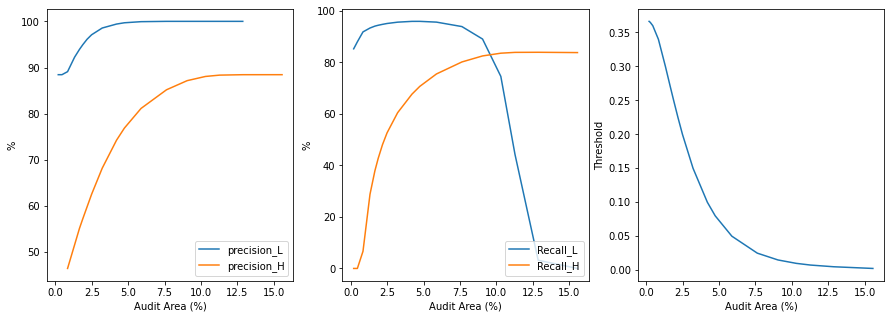

In [376]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m['AA']*100, m['precision_L']*100, label="precision_L")
ax1.plot(m['AA']*100, m['precision_H']*100, label="precision_H")
ax1.legend(loc="lower right")
ax1.set_ylabel('%')
ax1.set_xlabel('Audit Area (%)')

ax2.plot(m['AA']*100, m['recall_L']*100, label="Recall_L")
ax2.plot(m['AA']*100, m['recall_H']*100, label="Recall_H")
ax2.legend(loc="lower right")
ax2.set_ylabel('%')
ax2.set_xlabel('Audit Area (%)')

ax3.plot(m['AA']*100, np.asarray(threshold_list), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_AA.png', dpi=150, bbox_inches='tight')

In [377]:
xlim = [-0.3, 12.7]
xlim = [-0.1, 10.4]

ylim = [0, 105]


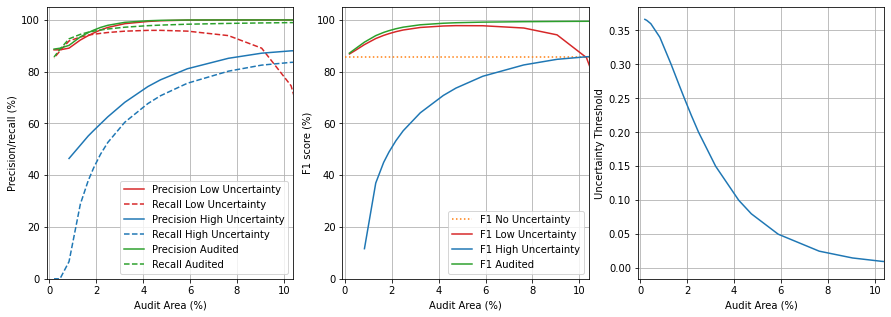

In [378]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m['AA']*100, m['precision_L']*100, 'C3-', label="Precision Low Uncertainty")
ax1.plot(m['AA']*100, m['recall_L']*100, 'C3--', label="Recall Low Uncertainty")
ax1.plot(m['AA']*100, m['precision_H']*100, 'C0-', label="Precision High Uncertainty")
ax1.plot(m['AA']*100, m['recall_H']*100, 'C0--', label="Recall High Uncertainty")
ax1.plot(m['AA']*100, m_audited['precision']*100, 'C2-', label="Precision Audited")
ax1.plot(m['AA']*100, m_audited['recall']*100, 'C2--', label="Recall Audited")

ax1.legend(loc="lower right")
ax1.set_ylabel('Precision/recall (%)')
ax1.set_xlabel('Audit Area (%)')
ax1.set_ylim(ylim)
ax1.set_xlim(xlim)
ax1.grid()

# ax2.plot(np.append(0, m['AA']*100), 
#     np.append(f1, np.ones_like(m['AA']) * f1), 
#     'C1:', label="F1 No Uncertainty")
ax2.plot(range(int(xlim[0]), int(xlim[1] + 2)), 
    np.ones(int(xlim[1] + 2)) * f1, 
    'C1:', label="F1 No Uncertainty")



ax2.plot(m['AA']*100, m['f1_L']*100, 'C3-', label="F1 Low Uncertainty")
ax2.plot(m['AA']*100, m['f1_H']*100, 'C0-', label="F1 High Uncertainty")
ax2.plot(m['AA']*100, m_audited['f1']*100, 'C2-', label="F1 Audited")

ax2.legend(loc="lower right")
ax2.set_ylabel('F1 score (%)')
ax2.set_xlabel('Audit Area (%)')
ax2.set_ylim(ylim)
ax2.set_xlim(xlim)

ax2.grid()
ax3.plot(m['AA']*100, np.asarray(threshold_list), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Uncertainty Threshold')
ax3.grid()
ax3.set_xlim(xlim)



# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_f1_AA.png', dpi=150, bbox_inches='tight')

In [379]:
np.append(np.append(0, m['AA']*100), 10.5)

array([ 0.        , 15.57207093, 12.87265283, 11.28015428, 10.30623165,
        9.05153505,  7.63306055,  5.88382051,  4.73866253,  4.19988404,
        3.21679564,  2.48961191,  2.17809392,  1.88347804,  1.65504481,
        1.31832696,  0.83641762,  0.45103789,  0.27844143,  0.19712777,
       10.5       ])

In [380]:
AA

0.032167956356824484

In [381]:


m

{'precision_L': array([       nan, 1.        , 1.        , 1.        , 1.        ,
        1.        , 0.99931542, 0.99691603, 0.99414072, 0.98557185,
        0.97100974, 0.96127965, 0.9494838 , 0.93931937, 0.92240636,
        0.89106187, 0.884497  , 0.884497  , 0.884497  ]),
 'recall_L': array([0.        , 0.03188406, 0.44278842, 0.74596098, 0.89103837,
        0.93949928, 0.95680022, 0.95978126, 0.95971203, 0.95664066,
        0.95145874, 0.94815387, 0.94463078, 0.94127086, 0.93390104,
        0.91880521, 0.88033243, 0.86172131, 0.85310469]),
 'recall_Ltotal': array([0.        , 0.00028465, 0.00764742, 0.03031046, 0.09472444,
        0.20760383, 0.36581204, 0.47592528, 0.52779423, 0.61877056,
        0.68490878, 0.71327164, 0.73952754, 0.75898044, 0.78715125,
        0.82570022, 0.83243921, 0.83243921, 0.83243921]),
 'AA': array([0.15572071, 0.12872653, 0.11280154, 0.10306232, 0.09051535,
        0.07633061, 0.05883821, 0.04738663, 0.04199884, 0.03216796,
        0.02489612, 0.021780

In [382]:
m_audited

{'precision': array([1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 0.99974526, 0.99850001, 0.99682888, 0.99076627,
        0.97925077, 0.97097124, 0.96049621, 0.95105138, 0.93447241,
        0.90180039, 0.89080887, 0.88852202, 0.8873953 ]),
 'recall': array([0.99281565, 0.99135699, 0.99037638, 0.98967769, 0.98841652,
        0.98663098, 0.98348349, 0.98005679, 0.97784361, 0.97195448,
        0.96505751, 0.9609975 , 0.95665284, 0.95264459, 0.94428759,
        0.9270329 , 0.88684277, 0.86642015, 0.85666306]),
 'f1': array([0.99639488, 0.99565974, 0.99516492, 0.99481207, 0.99417452,
        0.99327051, 0.9915477 , 0.98919244, 0.98724498, 0.98127023,
        0.97210233, 0.96595862, 0.95857068, 0.95184732, 0.93935436,
        0.91424258, 0.8888214 , 0.87733191, 0.87175841])}

In [383]:
# exp

In [384]:
threshold_list

[0.0025,
 0.005,
 0.0075,
 0.01,
 0.015,
 0.025,
 0.05,
 0.08,
 0.1,
 0.15,
 0.2,
 0.225,
 0.25,
 0.27,
 0.3,
 0.34,
 0.36,
 0.3648794801235199,
 0.3663794801235199]

In [385]:
# threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
#         0.25, 0.27, 0.3, 0.34, 0.36, np.max(uncertainty)-0.003, np.max(uncertainty)-0.0015]


In [386]:
predictor

<Predictor.pred_entropy: 3>

In [387]:

importlib.reload(_metrics)


# threshold_list = [0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
#         0.25, 0.27, 0.3, 0.34, 0.36, np.max(uncertainty)-0.003, np.max(uncertainty)-0.0015]
#threshold_list2 = [0.09] # exp 77 PA 50 runs
# threshold_list2 = [0.085] # exp 77 PA 30 runs
# threshold_list2 = [0.085] # exp 77 PA 10 runs
# threshold_list2 = [0.083] # exp 77 PA 5 runs
threshold_list2 = [0.065] # exp 77 PA 5 runs
threshold_list2 = [0.06] # exp 77 PA 5 runs
threshold_list2 = [0.0825] # exp 77 PA 3 runs

if predictor == Predictor.pred_entropy:
        if issubclass(type(dataset), PA):
                threshold_list2 = [0.163]
                threshold_list2 = [0.151]

        elif issubclass(type(dataset), MT):
                threshold_list2 = [0.116]
                threshold_list2 = [0.171]

ic(uncertainty.shape, label_mask_current_deforestation_test.shape)

metrics_values2 = _metrics.getAA_Recall(uncertainty, 
        label_mask_current_deforestation_test, 
        predicted_test, threshold_list2)

metric_values_audited2 = _metrics.getUncertaintyMetricsAudited(uncertainty, 
        label_mask_current_deforestation_test, 
        predicted_test, threshold_list2)



ic| uncertainty.shape: (54147114,)
    label_mask_current_deforestation_test.shape: (54147114,)


threshold 0.151
(52414197,) (52414197,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1732917,)
    predicted_test_classified_incorrect.shape: (1732917,)


cm_correct [[51931325     6756]
 [   20682   455434]]
cm_incorrect [[1401739   73059]
 [ 102347  155772]]


ic| TP_H + FN_H + FP_H + TN_H: 1732917
    len(label_mask_current_deforestation_test): 54147114
ic| TP_H + FN_H + FP_H + TN_H: 1732917
    len(label_mask_current_deforestation_test): 54147114


[0.98538263 0.95656101 0.6202837  0.03200387 0.68072945 0.60348909]
threshold 0.151
(54147114,) (54147114,)
cm_audited [[53406123     6756]
 [   20682   713553]]
[0.99062069 0.97183191]


In [388]:
m2 = {'precision_L': metrics_values2[:,0],
        'recall_L': metrics_values2[:,1],
        'recall_Ltotal': metrics_values2[:,2],
        'AA': metrics_values2[:,3],
        'precision_H': metrics_values2[:,4],
        'recall_H': metrics_values2[:,5]}

m_audited2 = {'precision': metric_values_audited2[:,0],
        'recall': metric_values_audited2[:,1]}

m2['f1_L'] = 2*m2['precision_L']*m2['recall_L']/(m2['precision_L']+m2['recall_L'])
m2['f1_H'] = 2*m2['precision_H']*m2['recall_H']/(m2['precision_H']+m2['recall_H'])

m_audited2['f1'] = 2*m_audited2['precision']*m_audited2['recall']/(m_audited2['precision']+m_audited2['recall'])

ic(m2)
ic(m_audited2)


ic| m2: {'AA': array([0.03200387]),
         'f1_H': array([0.63978643]),
         'f1_L': array([0.97075794]),
         'precision_H': array([0.68072945]),
         'precision_L': array([0.98538263]),
         'recall_H': array([0.60348909]),
         'recall_L': array([0.95656101]),
         'recall_Ltotal': array([0.6202837])}
ic| m_audited2: {'f1': array([0.98113636]),
                 'precision': array([0.99062069]),
                 'recall': array([0.97183191])}


{'precision': array([0.99062069]),
 'recall': array([0.97183191]),
 'f1': array([0.98113636])}

In [389]:
pred_entropy_unpad = utils_v1.unpadIm(pred_entropy, npad)
ic(pred_entropy_unpad.shape)

threshold_uncertainty = 0.1

uncertainty_mask = np.zeros_like(pred_entropy_unpad).astype(np.int8)
uncertainty_mask[pred_entropy_unpad >= threshold_uncertainty] = 1
ic(np.unique(uncertainty_mask, return_counts=True))


ic| pred_entropy_unpad.shape: (17730, 9200)
ic| np.unique(uncertainty_mask, return_counts=True): (array([0, 1], dtype=int8), array([157377057,   5738943], dtype=int64))


(array([0, 1], dtype=int8), array([157377057,   5738943], dtype=int64))

(-0.5, 9199.5, 17729.5, -0.5)

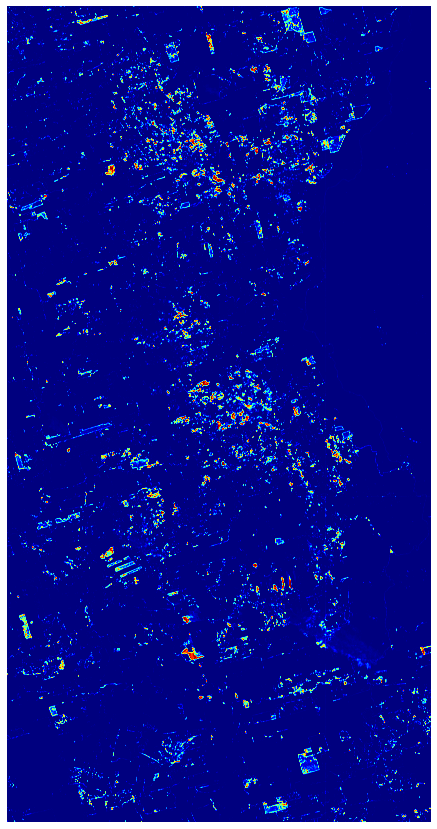

In [390]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(pred_entropy_to_show, cmap='jet')
plt.axis('off')


(-0.5, 9199.5, 17729.5, -0.5)

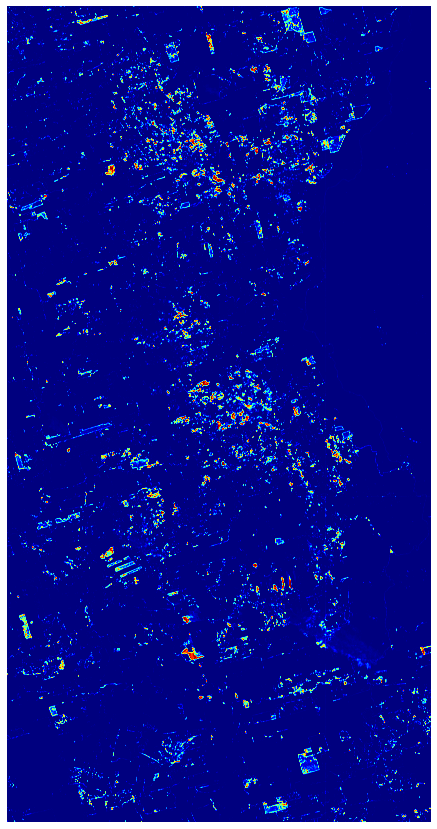

In [391]:

fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(pred_entropy_to_show, cmap='jet')
plt.axis('off')


(-0.5, 9199.5, 17729.5, -0.5)

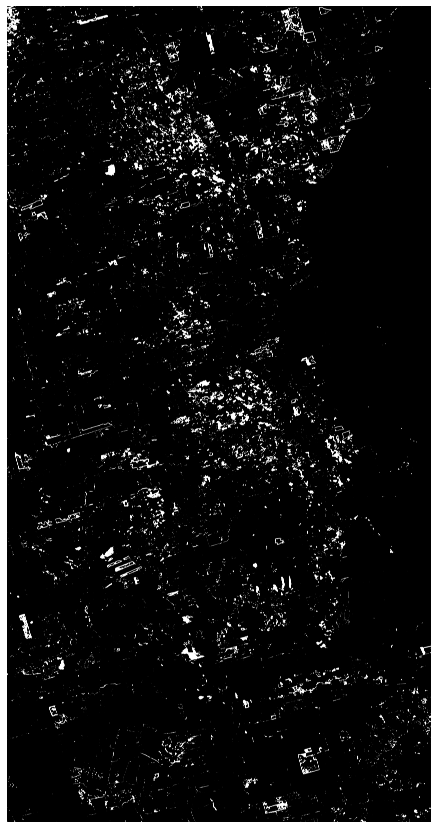

In [392]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(uncertainty_mask, cmap=plt.cm.gray)
plt.axis('off')


In [393]:
# np.unique(label_mask_val_valid, return_counts=True)

In [394]:
'''
importlib.reload(_metrics)

threshold_list_val = [0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]

loadThresholdMetrics = False
if loadThresholdMetrics == False:
        # threshold_list_val = [0.1]
        # y_test
        ic(uncertainty_val.shape, label_mask_val_valid.shape)
        importlib.reload(_metrics)

        metrics_values_val = _metrics.getAA_Recall(uncertainty_val, 
                label_mask_val_valid, 
                predicted_val, threshold_list_val)

        ic(metrics_values_val)
'''


'\nimportlib.reload(_metrics)\n\nthreshold_list_val = [0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]\n\nloadThresholdMetrics = False\nif loadThresholdMetrics == False:\n        # threshold_list_val = [0.1]\n        # y_test\n        ic(uncertainty_val.shape, label_mask_val_valid.shape)\n        importlib.reload(_metrics)\n\n        metrics_values_val = _metrics.getAA_Recall(uncertainty_val, \n                label_mask_val_valid, \n                predicted_val, threshold_list_val)\n\n        ic(metrics_values_val)\n'

In [395]:
'''
m_val = {'precision_L': metrics_values_val[:,0],
        'recall_L': metrics_values_val[:,1],
        'recall_Ltotal': metrics_values_val[:,2],
        'AA': metrics_values_val[:,3],
        'precision_H': metrics_values_val[:,4],
        'recall_H': metrics_values_val[:,5]}


save_figures=False
'''

"\nm_val = {'precision_L': metrics_values_val[:,0],\n        'recall_L': metrics_values_val[:,1],\n        'recall_Ltotal': metrics_values_val[:,2],\n        'AA': metrics_values_val[:,3],\n        'precision_H': metrics_values_val[:,4],\n        'recall_H': metrics_values_val[:,5]}\n\n\nsave_figures=False\n"

In [396]:
# threshold_list_val = [0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]


In [397]:
'''
plt.plot(m_val['precision_L']*100, m_val['AA']*100)
plt.title('Precision vs. To-Audit Area')
plt.xlabel('Precision (%)')
plt.ylabel('Audit Area (%)')
if True:
    plt.savefig('figures/precision_AA_val.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m_val['precision_L']*100, m_val['AA']*100)\nplt.title('Precision vs. To-Audit Area')\nplt.xlabel('Precision (%)')\nplt.ylabel('Audit Area (%)')\nif True:\n    plt.savefig('figures/precision_AA_val.png', dpi=150, bbox_inches='tight')\n"

In [398]:
'''
plt.plot(m_val['precision_L']*100, np.asarray(threshold_list_val))
plt.title('Precision vs. Threshold')
plt.xlabel('Precision (%)')
plt.ylabel('Threshold')
if True:
    plt.savefig('figures/precision_total_threshold_val.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m_val['precision_L']*100, np.asarray(threshold_list_val))\nplt.title('Precision vs. Threshold')\nplt.xlabel('Precision (%)')\nplt.ylabel('Threshold')\nif True:\n    plt.savefig('figures/precision_total_threshold_val.png', dpi=150, bbox_inches='tight')\n"

In [399]:
'''
plt.plot(m_val['recall_Ltotal']*100, m_val['AA']*100)
plt.title('Recall total vs. To-Audit Area')
plt.xlabel('Recall (%)')
plt.ylabel('Audit Area (%)')
if True:
    plt.savefig('figures/recall_total_AA_val.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m_val['recall_Ltotal']*100, m_val['AA']*100)\nplt.title('Recall total vs. To-Audit Area')\nplt.xlabel('Recall (%)')\nplt.ylabel('Audit Area (%)')\nif True:\n    plt.savefig('figures/recall_total_AA_val.png', dpi=150, bbox_inches='tight')\n"

In [400]:
'''
plt.plot(m_val['recall_Ltotal']*100, np.asarray(threshold_list_val))
plt.title('Recall total vs. Threshold')
plt.xlabel('Recall (%)')
plt.ylabel('Threshold')
if True:
    plt.savefig('figures/recall_total_threshold_val.png', dpi=150, bbox_inches='tight')
'''

"\nplt.plot(m_val['recall_Ltotal']*100, np.asarray(threshold_list_val))\nplt.title('Recall total vs. Threshold')\nplt.xlabel('Recall (%)')\nplt.ylabel('Threshold')\nif True:\n    plt.savefig('figures/recall_total_threshold_val.png', dpi=150, bbox_inches='tight')\n"

In [401]:
'''
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m_val['AA']*100, m_val['precision_L']*100, label="precision_L")
ax1.plot(m_val['AA']*100, m_val['precision_H']*100, label="precision_H")
ax1.legend(loc="lower right")
ax1.set_ylabel('%')
ax1.set_xlabel('Audit Area (%)')

ax2.plot(m_val['AA']*100, m_val['recall_L']*100, label="Recall_L")
ax2.plot(m_val['AA']*100, m_val['recall_H']*100, label="Recall_H")
ax2.legend(loc="lower right")
ax2.set_ylabel('%')
ax2.set_xlabel('Audit Area (%)')

ax3.plot(m_val['AA']*100, np.asarray(threshold_list_val), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_AA_val.png', dpi=150, bbox_inches='tight')
'''

'\nfig, (ax1, ax2, ax3) = plt.subplots(1, 3)\nfig.set_figheight(5)\nfig.set_figwidth(15)\nax1.plot(m_val[\'AA\']*100, m_val[\'precision_L\']*100, label="precision_L")\nax1.plot(m_val[\'AA\']*100, m_val[\'precision_H\']*100, label="precision_H")\nax1.legend(loc="lower right")\nax1.set_ylabel(\'%\')\nax1.set_xlabel(\'Audit Area (%)\')\n\nax2.plot(m_val[\'AA\']*100, m_val[\'recall_L\']*100, label="Recall_L")\nax2.plot(m_val[\'AA\']*100, m_val[\'recall_H\']*100, label="Recall_H")\nax2.legend(loc="lower right")\nax2.set_ylabel(\'%\')\nax2.set_xlabel(\'Audit Area (%)\')\n\nax3.plot(m_val[\'AA\']*100, np.asarray(threshold_list_val), label="AA")\nax3.set_xlabel(\'Audit Area (%)\')\nax3.set_ylabel(\'Threshold\')\n\n# if save_figures == True:\nif True:\n    plt.savefig(\'figures/recall_precision_AA_val.png\', dpi=150, bbox_inches=\'tight\')\n'

In [402]:
'''
m_val['f1_L'] = 2*m_val['precision_L']*m_val['recall_L']/(m_val['precision_L']+m_val['recall_L'])
m_val['f1_H'] = 2*m_val['precision_H']*m_val['recall_H']/(m_val['precision_H']+m_val['recall_H'])

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m_val['AA']*100, m_val['f1_L']*100, label="f1_L")
ax1.plot(m_val['AA']*100, m_val['f1_H']*100, label="f1_H")
ax1.legend(loc="lower right")
ax1.set_ylabel('%')
ax1.set_xlabel('Audit Area (%)')

ax2.plot(m_val['AA']*100, np.asarray(threshold_list_val), label="AA")
ax2.set_xlabel('Audit Area (%)')
ax2.set_ylabel('Threshold')

# if save_figures == True:
if True:
    plt.savefig('figures/f1_AA_val.png', dpi=150, bbox_inches='tight')
'''

'\nm_val[\'f1_L\'] = 2*m_val[\'precision_L\']*m_val[\'recall_L\']/(m_val[\'precision_L\']+m_val[\'recall_L\'])\nm_val[\'f1_H\'] = 2*m_val[\'precision_H\']*m_val[\'recall_H\']/(m_val[\'precision_H\']+m_val[\'recall_H\'])\n\nfig, (ax1, ax2) = plt.subplots(1, 2)\nfig.set_figheight(5)\nfig.set_figwidth(15)\nax1.plot(m_val[\'AA\']*100, m_val[\'f1_L\']*100, label="f1_L")\nax1.plot(m_val[\'AA\']*100, m_val[\'f1_H\']*100, label="f1_H")\nax1.legend(loc="lower right")\nax1.set_ylabel(\'%\')\nax1.set_xlabel(\'Audit Area (%)\')\n\nax2.plot(m_val[\'AA\']*100, np.asarray(threshold_list_val), label="AA")\nax2.set_xlabel(\'Audit Area (%)\')\nax2.set_ylabel(\'Threshold\')\n\n# if save_figures == True:\nif True:\n    plt.savefig(\'figures/f1_AA_val.png\', dpi=150, bbox_inches=\'tight\')\n'

In [403]:
'''
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m_val['AA']*100, m_val['precision_L']*100, 'C0-', label="Precision Low Uncertainty")
ax1.plot(m_val['AA']*100, m_val['recall_L']*100, 'C0--', label="Recall Low Uncertainty")
ax1.plot(m_val['AA']*100, m_val['precision_H']*100, 'C1-', label="Precision High Uncertainty")
ax1.plot(m_val['AA']*100, m_val['recall_H']*100, 'C1--', label="Recall High Uncertainty")
ax1.legend(loc="lower right")
ax1.set_ylabel('Precision/recall (%)')
ax1.set_xlabel('Audit Area (%)')
ax1.set_ylim(ylim)
ax1.set_xlim(xlim)

ax2.plot(m_val['AA']*100, m_val['f1_L']*100, label="F1 Low Uncertainty")
ax2.plot(m_val['AA']*100, m_val['f1_H']*100, label="F1 High Uncertainty")
ax2.legend(loc="lower right")
ax2.set_ylabel('F1 score (%)')
ax2.set_xlabel('Audit Area (%)')
ax2.set_ylim(ylim)
ax2.set_xlim(xlim)

ax3.plot(m_val['AA']*100, np.asarray(threshold_list_val), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')
ax3.set_xlim(xlim)

# if save_figures == True:
if True:
    plt.savefig('figures/recall_precision_AA_val.png', dpi=150, bbox_inches='tight')
'''

'\nfig, (ax1, ax2, ax3) = plt.subplots(1, 3)\nfig.set_figheight(5)\nfig.set_figwidth(15)\nax1.plot(m_val[\'AA\']*100, m_val[\'precision_L\']*100, \'C0-\', label="Precision Low Uncertainty")\nax1.plot(m_val[\'AA\']*100, m_val[\'recall_L\']*100, \'C0--\', label="Recall Low Uncertainty")\nax1.plot(m_val[\'AA\']*100, m_val[\'precision_H\']*100, \'C1-\', label="Precision High Uncertainty")\nax1.plot(m_val[\'AA\']*100, m_val[\'recall_H\']*100, \'C1--\', label="Recall High Uncertainty")\nax1.legend(loc="lower right")\nax1.set_ylabel(\'Precision/recall (%)\')\nax1.set_xlabel(\'Audit Area (%)\')\nax1.set_ylim(ylim)\nax1.set_xlim(xlim)\n\nax2.plot(m_val[\'AA\']*100, m_val[\'f1_L\']*100, label="F1 Low Uncertainty")\nax2.plot(m_val[\'AA\']*100, m_val[\'f1_H\']*100, label="F1 High Uncertainty")\nax2.legend(loc="lower right")\nax2.set_ylabel(\'F1 score (%)\')\nax2.set_xlabel(\'Audit Area (%)\')\nax2.set_ylim(ylim)\nax2.set_xlim(xlim)\n\nax3.plot(m_val[\'AA\']*100, np.asarray(threshold_list_val), lab